In [1]:
from virusPropagationModel import *
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import pandas

In [2]:
geopath = 'datafiles/'
geofiles = {1:'Buildings_Bad_Feilnbach_MA_1.csv',
            2:'Buildings_Bad_Feilnbach_MA_3.csv'}

In [3]:
modeledWorld1 = ModeledPopulatedWorld(1000,100, world_from_file=True, geofile_name=geopath+geofiles[1], agent_agent_infection=True, input_schedules='schedules_v1')
print('Number of agents: '+ str(modeledWorld1.number_of_people))
print('Distribution of initialized locations: ' + str(modeledWorld1.get_distribution_of_location_types()))

Number of agents: 5312
Distribution of initialized locations: {'hospital': 1, 'morgue': 1, 'work': 31, 'public': 22, 'school': 3, 'home': 2489}


In [4]:
simulation1 = Simulation(modeledWorld1,1000,run_immediately=False)
simulation1.simulate()

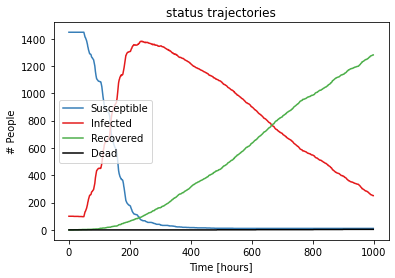

In [5]:
simulation1.plot_status_timecourse()

In [6]:
TC=simulation1.simulation_timecourse
Diagnosed_Curr=TC.loc[TC['Temporary_Flags']>=2]
Diagnosed_Cum=TC.loc[TC['Cumulative_Flags']>=2]
Infected_Curr=TC.loc[TC['Temporary_Flags']>=1]

Infected=Infected_Curr.groupby('time').count()
Diagnosed=Diagnosed_Curr.groupby('time').count()
Cumulative_Diagnosed=Diagnosed_Cum.groupby('time').count()

t=[]
Temp=[]
Cum=[]
Inf=[]
for i in range(1000):
    t.append(i)
    if i in Diagnosed.index:
        Temp.append(Diagnosed.loc[i,'status'])
    else:    
        Temp.append(0)
    if i in Cumulative_Diagnosed.index:
        Cum.append(Cumulative_Diagnosed.loc[i,'status'])
    else:    
        Cum.append(0)
    if i in Infected.index:
        Inf.append(Infected.loc[i,'status'])
    else:    
        Inf.append(0)


out=pandas.DataFrame()      
out['time']=t
out['Infected']=Inf
out['Diagnosed']=Temp
out['Cumulative_Diagnosed']=Cum

out['Removed']=out['Cumulative_Diagnosed']-out['Diagnosed']
#out
out.to_csv('ABM_Trajectories_InitialInfected100_InitialDiagnosed0.csv')

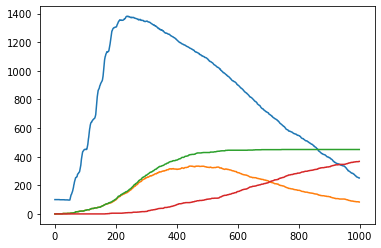

In [7]:
plt.plot(out['time'],out['Infected'])
plt.plot(out['time'],out['Diagnosed'])
plt.plot(out['time'],out['Cumulative_Diagnosed'])
plt.plot(out['time'],out['Removed'])

In [ ]:
Temp

In [ ]:
Cum

In [ ]:
Infected['status'].plot()

In [ ]:
Cumulative_Infected

In [8]:
Agents={str(p.ID):p.age for p in list(modeledWorld1.people)}
Agent_DF=pandas.DataFrame()
Agent_DF['ID']=[int(i) for i in list(Agents.keys())]
Agent_DF['Age']=list(Agents.values())
Agent_DF
Agent_DF.to_csv('ContactStuff_AgentsAge.csv')

Agents={str(p.ID):p.original_schedule['type'] for p in list(modeledWorld1.people)}
Agent_DF=pandas.DataFrame()
Agent_DF['ID']=[int(i) for i in list(Agents.keys())]
Agent_DF['Type']=list(Agents.values())
Agent_DF
Agent_DF.to_csv('ContactStuff_AgentsType.csv')

Locations={str(l.ID):l.location_type for l in list(modeledWorld1.locations.values())}
Location_DF=pandas.DataFrame()
Location_DF['ID']=[int(i) for i in list(Locations.keys())]
Location_DF['Type']=list(Locations.values())
Location_DF.to_csv('ContactStuff_Locs.csv')



In [9]:
simulation1 = Simulation(modeledWorld1,1000,run_immediately=False)
simulation2 = Simulation(modeledWorld1,120,run_immediately=False)
simulation1.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.3,'type':'replacement'}}})
simulation2.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.3,'type':'replacement'}}})

simulation1.simulate()
simulation1.simulation_timecourse.to_csv('InfectionStuff_Timecourse_NoMitigation.csv')

for p in list(simulation2.people):
    p.stay_home_instead_of_going_to('work')
    p.stay_home_instead_of_going_to('school')
    p.stay_home_instead_of_going_to('public')

simulation2.simulate()
simulation2.simulation_timecourse.to_csv('InfectionStuff_Timecourse_FullLockdown.csv')    

In [10]:
## Infection NW No Mitigation##
import time
import numpy

Timecourse=simulation1.simulation_timecourse

Interactions=Timecourse.loc[Timecourse['Infection_event']==1,:]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days

individuals=list(Timecourse['h_ID'].unique())

out={}
infection_matrix=numpy.zeros((len(individuals),len(individuals)))
for d in list(Interactions['day'].unique()):
    DayFrame=Interactions.loc[Interactions['day']==d,]
    did_infect_array=numpy.zeros((len(individuals),len(individuals)))
    got_infected_array=numpy.zeros((len(individuals),len(individuals)))
    for i in individuals:
        did_infect=DayFrame.loc[(DayFrame['h_ID']==i)&(DayFrame['status']==1),'Interaction_partner'].values
        got_infected=DayFrame.loc[(DayFrame['h_ID']==i)&(DayFrame['status']==0),'Interaction_partner'].values
        for a in did_infect:    
            did_infect_array[individuals.index(a),individuals.index(i)]=1
        for p in got_infected:    
            got_infected_array[individuals.index(i),individuals.index(p)]=1
    infection_matrix+=did_infect_array
    infection_matrix+=got_infected_array


Infection_matrix_NoMitigation=pandas.DataFrame(infection_matrix,index=individuals,columns=individuals)            
#Infection_matrix_NoMitigation.to_csv('InfectionMatrix_5workingdays_NoMitigation.csv')   




In [ ]:
## Infection NW Lockdown##
import time
import numpy

Timecourse=simulation2.simulation_timecourse

Interactions=Timecourse.loc[Timecourse['Infection_event']==1,:]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days

individuals=list(Timecourse['h_ID'].unique())

out={}
infection_matrix=numpy.zeros((len(individuals),len(individuals)))
for d in list(Interactions['day'].unique()):
    DayFrame=Interactions.loc[Interactions['day']==d,]
    did_infect_array=numpy.zeros((len(individuals),len(individuals)))
    got_infected_array=numpy.zeros((len(individuals),len(individuals)))
    for i in individuals:
        did_infect=DayFrame.loc[(DayFrame['h_ID']==i)&(DayFrame['status']==1),'Interaction_partner'].values
        got_infected=DayFrame.loc[(DayFrame['h_ID']==i)&(DayFrame['status']==0),'Interaction_partner'].values
        for a in did_infect:    
            did_infect_array[individuals.index(a),individuals.index(i)]=1
        for p in got_infected:    
            got_infected_array[individuals.index(i),individuals.index(p)]=1
    infection_matrix+=did_infect_array
    infection_matrix+=got_infected_array


Infection_matrix_Lockdown=pandas.DataFrame(infection_matrix,index=individuals,columns=individuals)            
#Infection_matrix_Lockdown.to_csv('InfectionMatrix_5workingdays_Lockdown.csv')   





In [ ]:
def build_infection_matrix(Contact_matrix,days=5):
    #Contact_matrix0.index=Contact_matrix0['Unnamed: 0'].values
    #Contact_matrix=Contact_matrix0.drop(columns=['Unnamed: 0'])
    Contact_matrix['AgeGroup_subject']=[-1]*Contact_matrix.shape[0]
    for i in list(Contact_matrix.index):
        agePerson=Ages.loc[Ages['ID']==i,'AgeGroup'].values[0]
        Contact_matrix.loc[i,'AgeGroup_subject']=agePerson
    CMgroup=Contact_matrix.groupby(['AgeGroup_subject']).sum()
    CMgroup.loc['AgeGroup_object',:]=[-1]*CMgroup.shape[1]
    for i in list(CMgroup.columns):
        agePerson=Ages.loc[Ages['ID']==int(i),'AgeGroup'].values[0]
        CMgroup.loc['AgeGroup_object',i]=agePerson
    Out=CMgroup.transpose().groupby(['AgeGroup_object']).sum()
    #perday=Out[::-1]/days
    perday=Out/days
    return(perday)

#We defined 14 age groups (0-4 y, 5-9 y, 10-14 y, 15-19 y, 20-24 y, 25-29 y, 30-34 y, 35-39 y, 40-44 y, 45-49 y, 50-54 y, 55-59 y, 60-64 y, 65 y and over)
Ages=pandas.read_csv('ContactStuff_AgentsAge.csv')
age_groups=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
Ages['AgeGroup']=[-1]*Ages.shape[0]
for i in age_groups:
    age_index=age_groups.index(i)
    if age_groups.index(i)<len(age_groups)-1:
        lower_bound=i
        upper_bound=age_groups[age_index+1]
        agent_ids=Ages.loc[(Ages['Age']>=lower_bound)&(Ages['Age']<upper_bound),'ID']
        Ages.loc[Ages['ID'].isin(agent_ids),'AgeGroup']=int(i)
    else:    
        lower_bound=i
        agent_ids=Ages.loc[Ages['Age']>=lower_bound,'ID']
        Ages.loc[Ages['ID'].isin(agent_ids),'AgeGroup']=int(i)

        
Infection_HeatmapDF_baseline=build_infection_matrix(Infection_matrix_NoMitigation,5)
Infection_HeatmapDF_lockdown=build_infection_matrix(Infection_matrix_Lockdown,5)





In [ ]:
## Contact NW No Mitigation##

import time
import numpy

Timecourse=simulation1.simulation_timecourse
Interactions=Timecourse.loc[Timecourse['Interaction_partner']!=-1,:]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days

individuals=list(Timecourse['h_ID'].unique())
out={}
contact_matrix=numpy.zeros((len(individuals),len(individuals)))
for d in list(Interactions['day'].unique()):
    DayFrame=Interactions.loc[Interactions['day']==d,]
    active=numpy.zeros((len(individuals),len(individuals)))
    passive=numpy.zeros((len(individuals),len(individuals)))
    for i in individuals:
        active_contact=DayFrame.loc[DayFrame['h_ID']==i,'Interaction_partner'].values
        passive_contact=DayFrame.loc[DayFrame['Interaction_partner']==i,'h_ID'].values
        for a in active_contact:    
            active[individuals.index(i),individuals.index(a)]=1
            active[individuals.index(a),individuals.index(i)]=1
        for p in passive_contact:    
            passive[individuals.index(p),individuals.index(i)]=1
            passive[individuals.index(i),individuals.index(p)]=1
    contact_matrix+=active
    contact_matrix+=passive


Contact_matrix_NoMitigation=pandas.DataFrame(contact_matrix,index=individuals,columns=individuals)            
#Infection_matrix_NoMitigation.to_csv('ContactMatrix_5workingdays_NoMitigation.csv')   
    



In [ ]:
## Contact NW Lockdown##

import time
import numpy

Timecourse=simulation2.simulation_timecourse
Interactions=Timecourse.loc[Timecourse['Interaction_partner']!=-1,:]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days

individuals=list(Timecourse['h_ID'].unique())
out={}
contact_matrix=numpy.zeros((len(individuals),len(individuals)))
for d in list(Interactions['day'].unique()):
    DayFrame=Interactions.loc[Interactions['day']==d,]
    active=numpy.zeros((len(individuals),len(individuals)))
    passive=numpy.zeros((len(individuals),len(individuals)))
    for i in individuals:
        active_contact=DayFrame.loc[DayFrame['h_ID']==i,'Interaction_partner'].values
        passive_contact=DayFrame.loc[DayFrame['Interaction_partner']==i,'h_ID'].values
        for a in active_contact:    
            active[individuals.index(i),individuals.index(a)]=1
            active[individuals.index(a),individuals.index(i)]=1
        for p in passive_contact:    
            passive[individuals.index(p),individuals.index(i)]=1
            passive[individuals.index(i),individuals.index(p)]=1
    contact_matrix+=active
    contact_matrix+=passive


Contact_matrix_Lockdown=pandas.DataFrame(contact_matrix,index=individuals,columns=individuals)            
#Infection_matrix_Lockdown.to_csv('ContactMatrix_5workingdays_Lockdown.csv')   
    




In [ ]:
def build_contact_matrix(Contact_matrix,days=5):
    #Contact_matrix0.index=Contact_matrix0['Unnamed: 0'].values
    #Contact_matrix=Contact_matrix0.drop(columns=['Unnamed: 0'])
    Contact_matrix['AgeGroup_subject']=[-1]*Contact_matrix.shape[0]
    for i in list(Contact_matrix.index):
        agePerson=Ages.loc[Ages['ID']==i,'AgeGroup'].values[0]
        Contact_matrix.loc[i,'AgeGroup_subject']=agePerson
    CMgroup=Contact_matrix.groupby(['AgeGroup_subject']).sum() #sum
    CMgroup.loc['AgeGroup_object',:]=[-1]*CMgroup.shape[1]
    for i in list(CMgroup.columns):
        agePerson=Ages.loc[Ages['ID']==int(i),'AgeGroup'].values[0]
        CMgroup.loc['AgeGroup_object',i]=agePerson
    Out=CMgroup.transpose().groupby(['AgeGroup_object']).sum() #mean
    #perday=Out[::-1]/days
    perday=Out/days
    return(perday)

#We defined 14 age groups (0-4 y, 5-9 y, 10-14 y, 15-19 y, 20-24 y, 25-29 y, 30-34 y, 35-39 y, 40-44 y, 45-49 y, 50-54 y, 55-59 y, 60-64 y, 65 y and over)
Ages=pandas.read_csv('ContactStuff_AgentsAge.csv')
age_groups=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
Ages['AgeGroup']=[-1]*Ages.shape[0]
for i in age_groups:
    age_index=age_groups.index(i)
    if age_groups.index(i)<len(age_groups)-1:
        lower_bound=i
        upper_bound=age_groups[age_index+1]
        agent_ids=Ages.loc[(Ages['Age']>=lower_bound)&(Ages['Age']<upper_bound),'ID']
        Ages.loc[Ages['ID'].isin(agent_ids),'AgeGroup']=int(i)
    else:    
        lower_bound=i
        agent_ids=Ages.loc[Ages['Age']>=lower_bound,'ID']
        Ages.loc[Ages['ID'].isin(agent_ids),'AgeGroup']=int(i)

        
HeatmapDF_lockdown=build_contact_matrix(Contact_matrix_Lockdown,5)
HeatmapDF_baseline=build_contact_matrix(Contact_matrix_NoMitigation,5)




In [ ]:
#plt.figure(figsize=(10, 5))

#plt.subplot(1, 2, 1)

#chosenColorMap=plt.cm.Blues
chosenColorMap=plt.cm.Reds

import math
DiffDF=Infection_HeatmapDF_baseline-Infection_HeatmapDF_lockdown



max_tot=max([Infection_HeatmapDF_baseline.max().max(),Infection_HeatmapDF_lockdown.max().max()])
min_tot=min([Infection_HeatmapDF_baseline.min().min(),Infection_HeatmapDF_lockdown.min().min()])

y_tick_positions=np.arange(0.5, len(Infection_HeatmapDF_lockdown.index), 1)[::2]
x_tick_positions=np.arange(0.5, len(Infection_HeatmapDF_lockdown.index), 1)[::2]
x_tick_labels=[int(i) for i in Infection_HeatmapDF_lockdown.columns][::2]
y_tick_labels=[int(i) for i in Infection_HeatmapDF_lockdown.index][::2]



plt.figure(figsize=(18/1.25, 5/1.25))

plt.subplot(1, 3, 1)
heatmap=plt.pcolor(Infection_HeatmapDF_baseline, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)
plt.colorbar(heatmap)
plt.title('Infections per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Infection receiver (age-groups)')
plt.ylabel('Infection donor (age-groups)')

plt.subplot(1, 3, 2)
heatmap=plt.pcolor(Infection_HeatmapDF_lockdown, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)
plt.colorbar(heatmap)
plt.title('Lockdown infections per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Infection receiver (age-groups)')
plt.ylabel('Infection donor (age-groups)')

plt.subplot(1, 3, 3)
heatmap=plt.pcolor(DiffDF, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)
plt.colorbar(heatmap)
plt.title('Infection difference per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Infection receiver (age-groups)')
plt.ylabel('Infection donor (age-groups)')
plt.tight_layout()
plt.savefig('InfectionAgeGroupHeatmaps_5days_FigS10.svg')
plt.show()

In [ ]:
#plt.figure(figsize=(10, 5))

#plt.subplot(1, 2, 1)

#chosenColorMap=plt.cm.Blues
chosenColorMap=plt.cm.Blues

import math
DiffDF=HeatmapDF_baseline-HeatmapDF_lockdown

y_tick_positions=np.arange(0.5, len(HeatmapDF_baseline.index), 1)[::2]
x_tick_positions=np.arange(0.5, len(HeatmapDF_baseline.index), 1)[::2]
x_tick_labels=[int(i) for i in HeatmapDF_baseline.columns][::2]
y_tick_labels=[int(i) for i in HeatmapDF_baseline.index][::2]



max_tot=math.ceil(max([HeatmapDF_baseline.max().max(),HeatmapDF_lockdown.max().max()]))
min_tot=int(min([HeatmapDF_baseline.min().min(),HeatmapDF_lockdown.min().min()]))


plt.figure(figsize=(18/1.25, 5/1.25))
plt.subplot(1, 3, 1)
heatmap=plt.pcolor(HeatmapDF_baseline, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
# manually implement taking only every second tick.
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)
plt.colorbar(heatmap)
plt.title('Contacts per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Individuals (age-groups)')
plt.ylabel('Individuals (age-groups)')
plt.subplot(1, 3, 2)
heatmap=plt.pcolor(HeatmapDF_lockdown, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)

plt.colorbar(heatmap)
plt.title('Lockdown contacts per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Individuals (age-groups)')
plt.ylabel('Individuals (age-groups)')
plt.subplot(1, 3, 3)
heatmap=plt.pcolor(DiffDF, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)

plt.colorbar(heatmap)
plt.title('Contact difference per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Individuals (age-groups)')
plt.ylabel('Individuals (age-groups)')

plt.tight_layout()
plt.savefig('ContactAgeGroupHeatmaps_5days_SumSumSymmetry.svg')
plt.show()

In [ ]:
#plt.figure(figsize=(10, 5))

#plt.subplot(1, 2, 1)

#chosenColorMap=plt.cm.Blues
chosenColorMap=plt.cm.Reds

import math

max_tot1=max([HeatmapDF_baseline.max().max(),HeatmapDF_baseline.max().max()])
min_tot1=min([HeatmapDF_baseline.min().min(),HeatmapDF_baseline.min().min()])

max_tot2=max([Infection_HeatmapDF_baseline.max().max(),Infection_HeatmapDF_baseline.max().max()])
min_tot2=min([Infection_HeatmapDF_baseline.min().min(),Infection_HeatmapDF_baseline.min().min()])

y_tick_positions1=np.arange(0.5, len(HeatmapDF_baseline.index), 1)[::2]
x_tick_positions1=np.arange(0.5, len(HeatmapDF_baseline.index), 1)[::2]
x_tick_labels1=[int(i) for i in HeatmapDF_baseline.columns][::2]
y_tick_labels1=[int(i) for i in HeatmapDF_baseline.index][::2]

y_tick_positions2=np.arange(0.5, len(Infection_HeatmapDF_baseline.index), 1)[::2]
x_tick_positions2=np.arange(0.5, len(Infection_HeatmapDF_baseline.index), 1)[::2]
x_tick_labels2=[int(i) for i in Infection_HeatmapDF_baseline.columns][::2]
y_tick_labels2=[int(i) for i in Infection_HeatmapDF_baseline.index][::2]



plt.figure(figsize=(12/1.25, 5/1.25))
plt.subplot(1, 2, 1)
heatmap=plt.pcolor(HeatmapDF_baseline, cmap=plt.cm.Blues, vmin = min_tot1, vmax = max_tot1)
plt.yticks(y_tick_positions1, y_tick_labels1)
plt.xticks(x_tick_positions1, x_tick_labels1)
plt.colorbar(heatmap)
plt.title('Contacts per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Individuals (age-groups)')
plt.ylabel('Individuals (age-groups)')

plt.subplot(1, 2, 2)
heatmap=plt.pcolor(Infection_HeatmapDF_baseline, cmap=plt.cm.Reds, vmin = min_tot2, vmax = max_tot2)
plt.yticks(y_tick_positions2, y_tick_labels2)
plt.xticks(x_tick_positions2, x_tick_labels2)
plt.colorbar(heatmap)
plt.title('Infections per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Infection receiver (age-groups)')
plt.ylabel('Infection donor (age-groups)')

plt.tight_layout()
plt.savefig('InfectionsContactsAgeGroupHeatmaps_5days_Fig1.svg')
plt.show()

In [ ]:
Infection_matrix_NoMitigation.to_csv('InfectionMatrix_5workingdays_NoMitigation.csv')   
Infection_matrix_Lockdown.to_csv('InfectionMatrix_5workingdays_Lockdown.csv')   
Contact_matrix_NoMitigation.to_csv('ContactMatrix_5workingdays_NoMitigation.csv')   
Contact_matrix_Lockdown.to_csv('ContactMatrix_5workingdays_Lockdown.csv')   







In [ ]:
## Infection NW ##

# Baseline
Timecourse=simulation1.simulation_timecourse
Interactions=Timecourse.loc[Timecourse['Infection_event']==1,:]
Interactions['InfectionLocType']=[Location_DF.loc[Location_DF['ID']==i,'Type'].values[0] for i in Interactions['loc']]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days
locTypes=list(Interactions['InfectionLocType'].unique())
days=list(Interactions['day'].unique())
out_base=pandas.DataFrame(0,index=locTypes,columns=days)
for i in days:
    Group=pandas.DataFrame(Interactions.loc[Interactions['day']==i,:].groupby(['InfectionLocType']).sum())
    for j in locTypes:
        if j in Group.index:
            out_base.loc[j,i]=Group.loc[j,'Infection_event']

# Lockdown
Timecourse=simulation2.simulation_timecourse
Interactions=Timecourse.loc[Timecourse['Infection_event']==1,:]
Interactions['InfectionLocType']=[Location_DF.loc[Location_DF['ID']==i,'Type'].values[0] for i in Interactions['loc']]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days
out_lockdown=pandas.DataFrame(0,index=locTypes,columns=days)
for i in days:
    Group=pandas.DataFrame(Interactions.loc[Interactions['day']==i,:].groupby(['InfectionLocType']).sum())
    for j in locTypes:
        if j in Group.index:
            out_lockdown.loc[j,i]=Group.loc[j,'Infection_event']



Diff=out_base-out_lockdown


chosenColorMap=plt.cm.Reds

plt.figure(figsize=(18/1.25, 5/1.25))
plt.subplot(1, 3, 1)
heatmap=plt.pcolor(out_base, cmap=chosenColorMap, vmin = 0, vmax = out_base.max().max())
plt.yticks(np.arange(0.5, len(out_base.index), 1), locTypes)
plt.xticks(np.arange(0.5, len(out_base.columns), 1), days)
plt.colorbar(heatmap)
plt.title('Baseline infections per location-type')
#plt.ylim((-0.1,4))
plt.xlabel('Day')
plt.ylabel('Location type')

plt.subplot(1, 3, 2)
heatmap=plt.pcolor(out_lockdown, cmap=chosenColorMap, vmin = 0, vmax = out_base.max().max())
plt.yticks(np.arange(0.5, len(out_lockdown.index), 1), locTypes)
plt.xticks(np.arange(0.5, len(out_lockdown.columns), 1), days)
plt.colorbar(heatmap)
plt.title('Lockdown infections per location-type')
#plt.ylim((-0.1,4))
plt.xlabel('Day')
plt.ylabel('Location type')

plt.subplot(1, 3, 3)
heatmap=plt.pcolor(Diff, cmap=chosenColorMap, vmin = 0, vmax = out_base.max().max())
plt.yticks(np.arange(0.5, len(Diff.index), 1), locTypes)
plt.xticks(np.arange(0.5, len(Diff.columns), 1), days)
plt.colorbar(heatmap)
plt.title('Difference in infections per location-type')
#plt.ylim((-0.1,4))
plt.xlabel('Day')
plt.ylabel('Location type')


plt.tight_layout()
plt.savefig('InfectionLocationTypesHeatmaps.svg')
plt.show()





In [ ]:
Timecourse=simulation1.simulation_timecourse
Interactions=Timecourse.loc[Timecourse['Infection_event']==1,:]
Interactions['InfectionLocType']=[Location_DF.loc[Location_DF['ID']==i,'Type'].values[0] for i in Interactions['loc']]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days


In [ ]:
## Infection NW ##

# Baseline
Timecourse=simulation1.simulation_timecourse
Interactions=Timecourse.loc[Timecourse['Infection_event']==1,:]
Interactions['InfectionLocType']=[Location_DF.loc[Location_DF['ID']==i,'Type'].values[0] for i in Interactions['loc']]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days
locTypes=list(Interactions['InfectionLocType'].unique())
days=list(Interactions['day'].unique())
out_base=pandas.DataFrame(0,index=locTypes,columns=days)
for i in days:
    Group=pandas.DataFrame(Interactions.loc[Interactions['day']==i,:].groupby(['InfectionLocType']).sum())
    for j in locTypes:
        if j in Group.index:
            out_base.loc[j,i]=Group.loc[j,'Infection_event']

# Lockdown
Timecourse=simulation2.simulation_timecourse
Interactions=Timecourse.loc[Timecourse['Infection_event']==1,:]
Interactions['InfectionLocType']=[Location_DF.loc[Location_DF['ID']==i,'Type'].values[0] for i in Interactions['loc']]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days
out_lockdown=pandas.DataFrame(0,index=locTypes,columns=days)
for i in days:
    Group=pandas.DataFrame(Interactions.loc[Interactions['day']==i,:].groupby(['InfectionLocType']).sum())
    for j in locTypes:
        if j in Group.index:
            out_lockdown.loc[j,i]=Group.loc[j,'Infection_event']



Diff=out_base-out_lockdown


chosenColorMap=plt.cm.Reds

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
heatmap=plt.pcolor(out_base, cmap=chosenColorMap, vmin = 0, vmax = out_base.max().max())
plt.yticks(np.arange(0.5, len(out_base.index), 1), locTypes)
plt.xticks(np.arange(0.5, len(out_base.columns), 1), days)
plt.colorbar(heatmap)
plt.title('Baseline infections per location-type')
#plt.ylim((-0.1,4))
plt.xlabel('Day')
plt.ylabel('Location type')

plt.subplot(1, 3, 2)
heatmap=plt.pcolor(out_lockdown, cmap=chosenColorMap, vmin = 0, vmax = out_lockdown.max().max())
plt.yticks(np.arange(0.5, len(out_lockdown.index), 1), locTypes)
plt.xticks(np.arange(0.5, len(out_lockdown.columns), 1), days)
plt.colorbar(heatmap)
plt.title('Lockdown infections per location-type')
#plt.ylim((-0.1,4))
plt.xlabel('Day')
plt.ylabel('Location type')

plt.subplot(1, 3, 3)
heatmap=plt.pcolor(Diff, cmap=chosenColorMap, vmin = 0, vmax = out_base.max().max())
plt.yticks(np.arange(0.5, len(Diff.index), 1), locTypes)
plt.xticks(np.arange(0.5, len(Diff.columns), 1), days)
plt.colorbar(heatmap)
plt.title('Difference in infections per location-type')
#plt.ylim((-0.1,4))
plt.xlabel('Day')
plt.ylabel('Location type')


plt.tight_layout()
plt.savefig('InfectionLocationTypesHeatmaps.svg')
plt.show()




In [ ]:
import time
import numpy

Timecourse=simulation1.simulation_timecourse
Interactions=Timecourse.loc[Timecourse['Infection_event']==1,:]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days

individuals=list(Timecourse['h_ID'].unique())
out={}
contact_matrix=numpy.zeros((len(individuals),len(individuals)))
for d in list(Interactions['day'].unique()):
    DayFrame=Interactions.loc[Interactions['day']==d,]
    active=numpy.zeros((len(individuals),len(individuals)))
    passive=numpy.zeros((len(individuals),len(individuals)))
    for i in individuals:
        active_contact=DayFrame.loc[DayFrame['h_ID']==i,'Interaction_partner'].values
        passive_contact=DayFrame.loc[DayFrame['Interaction_partner']==i,'h_ID'].values
        for a in active_contact:    
            active[individuals.index(i),individuals.index(a)]=1
        for p in passive_contact:    
            passive[individuals.index(p),individuals.index(i)]=1
    contact_matrix+=active
    contact_matrix+=passive


CM_DF=pandas.DataFrame(contact_matrix,index=individuals,columns=individuals)            
CM_DF.to_csv('InfectionMatrix_5workingdays_NoMitigation.csv')   



In [ ]:
import time
import numpy

Timecourse=simulation2.simulation_timecourse
Interactions=Timecourse.loc[Timecourse['Infection_event']==1,:]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days

individuals=list(Timecourse['h_ID'].unique())
out={}
contact_matrix=numpy.zeros((len(individuals),len(individuals)))
for d in list(Interactions['day'].unique()):
    DayFrame=Interactions.loc[Interactions['day']==d,]
    active=numpy.zeros((len(individuals),len(individuals)))
    passive=numpy.zeros((len(individuals),len(individuals)))
    for i in individuals:
        active_contact=DayFrame.loc[DayFrame['h_ID']==i,'Interaction_partner'].values
        passive_contact=DayFrame.loc[DayFrame['Interaction_partner']==i,'h_ID'].values
        for a in active_contact:    
            active[individuals.index(i),individuals.index(a)]=1
        for p in passive_contact:    
            passive[individuals.index(p),individuals.index(i)]=1
    contact_matrix+=active
    contact_matrix+=passive


CM_DF=pandas.DataFrame(contact_matrix,index=individuals,columns=individuals)            
CM_DF.to_csv('InfectionMatrix_5workingdays_FullLockdown.csv')   




In [ ]:
import time
import numpy

Timecourse=simulation1.simulation_timecourse
Interactions=Timecourse.loc[Timecourse['Interaction_partner']!=-1,:]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days

individuals=list(Timecourse['h_ID'].unique())
out={}
contact_matrix=numpy.zeros((len(individuals),len(individuals)))
for d in list(Interactions['day'].unique()):
    DayFrame=Interactions.loc[Interactions['day']==d,]
    active=numpy.zeros((len(individuals),len(individuals)))
    passive=numpy.zeros((len(individuals),len(individuals)))
    for i in individuals:
        active_contact=DayFrame.loc[DayFrame['h_ID']==i,'Interaction_partner'].values
        passive_contact=DayFrame.loc[DayFrame['Interaction_partner']==i,'h_ID'].values
        for a in active_contact:    
            active[individuals.index(i),individuals.index(a)]=1
        for p in passive_contact:    
            passive[individuals.index(p),individuals.index(i)]=1
    contact_matrix+=active
    contact_matrix+=passive


CM_DF=pandas.DataFrame(contact_matrix,index=individuals,columns=individuals)            
CM_DF.to_csv('ContactMatrix_5workingdays_NoMitigation.csv')   
    


In [ ]:
import time
import numpy

Timecourse=simulation2.simulation_timecourse
Interactions=Timecourse.loc[Timecourse['Interaction_partner']!=-1,:]
Days=[int(i/24) for i in Interactions['time']]
Interactions['day']=Days

individuals=list(Timecourse['h_ID'].unique())
out={}
contact_matrix=numpy.zeros((len(individuals),len(individuals)))
for d in list(Interactions['day'].unique()):
    DayFrame=Interactions.loc[Interactions['day']==d,]
    active=numpy.zeros((len(individuals),len(individuals)))
    passive=numpy.zeros((len(individuals),len(individuals)))
    for i in individuals:
        active_contact=DayFrame.loc[DayFrame['h_ID']==i,'Interaction_partner'].values
        passive_contact=DayFrame.loc[DayFrame['Interaction_partner']==i,'h_ID'].values
        for a in active_contact:    
            active[individuals.index(i),individuals.index(a)]=1
        for p in passive_contact:    
            passive[individuals.index(p),individuals.index(i)]=1
    contact_matrix+=active
    contact_matrix+=passive


CM_DF=pandas.DataFrame(contact_matrix,index=individuals,columns=individuals)            
CM_DF.to_csv('ContactMatrix_5workingdays_FullLockdown.csv')   
    



In [ ]:
ContactMatrix_noMitigation=pandas.read_csv('ContactMatrix_5workingdays_NoMitigation.csv')
ContactMatrix_fullLockdown=pandas.read_csv('ContactMatrix_5workingdays_FullLockdown.csv')
#InfectionMatrix_noMitigation=pandas.read_csv('InfectionMatrix_5workingdays_NoMitigation.csv')
#InfectionMatrix_fullLockdown=pandas.read_csv('InfectionMatrix_5workingdays_FullLockdown.csv')



In [ ]:
InfectionMatrix_noMitigation=pandas.read_csv('InfectionMatrix_5workingdays_NoMitigation.csv')
InfectionMatrix_fullLockdown=pandas.read_csv('InfectionMatrix_5workingdays_FullLockdown.csv')



In [ ]:
InfectionMatrix_noMitigation.max()

In [ ]:
def build_contact_matrix(Contact_matrix0,days=5):
    Contact_matrix0.index=Contact_matrix0['Unnamed: 0'].values
    Contact_matrix=Contact_matrix0.drop(columns=['Unnamed: 0'])
    Contact_matrix['AgeGroup_subject']=[-1]*Contact_matrix.shape[0]
    for i in list(Contact_matrix.index):
        agePerson=Ages.loc[Ages['ID']==i,'AgeGroup'].values[0]
        Contact_matrix.loc[i,'AgeGroup_subject']=agePerson
    CMgroup=Contact_matrix.groupby(['AgeGroup_subject']).mean() #sum
    CMgroup.loc['AgeGroup_object',:]=[-1]*CMgroup.shape[1]
    for i in list(CMgroup.columns):
        agePerson=Ages.loc[Ages['ID']==int(i),'AgeGroup'].values[0]
        CMgroup.loc['AgeGroup_object',i]=agePerson
    Out=CMgroup.transpose().groupby(['AgeGroup_object']).sum() #mean
    #perday=Out[::-1]/days
    perday=Out/days
    return(perday)

#We defined 14 age groups (0-4 y, 5-9 y, 10-14 y, 15-19 y, 20-24 y, 25-29 y, 30-34 y, 35-39 y, 40-44 y, 45-49 y, 50-54 y, 55-59 y, 60-64 y, 65 y and over)
Ages=pandas.read_csv('ContactStuff_AgentsAge.csv')
age_groups=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
Ages['AgeGroup']=[-1]*Ages.shape[0]
for i in age_groups:
    age_index=age_groups.index(i)
    if age_groups.index(i)<len(age_groups)-1:
        lower_bound=i
        upper_bound=age_groups[age_index+1]
        agent_ids=Ages.loc[(Ages['Age']>=lower_bound)&(Ages['Age']<upper_bound),'ID']
        Ages.loc[Ages['ID'].isin(agent_ids),'AgeGroup']=int(i)
    else:    
        lower_bound=i
        agent_ids=Ages.loc[Ages['Age']>=lower_bound,'ID']
        Ages.loc[Ages['ID'].isin(agent_ids),'AgeGroup']=int(i)

        
HeatmapDF_lockdown=build_contact_matrix(ContactMatrix_fullLockdown,5)
HeatmapDF_baseline=build_contact_matrix(ContactMatrix_noMitigation,5)



In [ ]:
def build_infection_matrix(Contact_matrix0,days=5):
    Contact_matrix0.index=Contact_matrix0['Unnamed: 0'].values
    Contact_matrix=Contact_matrix0.drop(columns=['Unnamed: 0'])
    Contact_matrix['AgeGroup_subject']=[-1]*Contact_matrix.shape[0]
    for i in list(Contact_matrix.index):
        agePerson=Ages.loc[Ages['ID']==i,'AgeGroup'].values[0]
        Contact_matrix.loc[i,'AgeGroup_subject']=agePerson
    CMgroup=Contact_matrix.groupby(['AgeGroup_subject']).mean()
    CMgroup.loc['AgeGroup_object',:]=[-1]*CMgroup.shape[1]
    for i in list(CMgroup.columns):
        agePerson=Ages.loc[Ages['ID']==int(i),'AgeGroup'].values[0]
        CMgroup.loc['AgeGroup_object',i]=agePerson
    Out=CMgroup.transpose().groupby(['AgeGroup_object']).sum()
    #perday=Out[::-1]/days
    perday=Out/days
    return(perday)

#We defined 14 age groups (0-4 y, 5-9 y, 10-14 y, 15-19 y, 20-24 y, 25-29 y, 30-34 y, 35-39 y, 40-44 y, 45-49 y, 50-54 y, 55-59 y, 60-64 y, 65 y and over)
Ages=pandas.read_csv('ContactStuff_AgentsAge.csv')
age_groups=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
Ages['AgeGroup']=[-1]*Ages.shape[0]
for i in age_groups:
    age_index=age_groups.index(i)
    if age_groups.index(i)<len(age_groups)-1:
        lower_bound=i
        upper_bound=age_groups[age_index+1]
        agent_ids=Ages.loc[(Ages['Age']>=lower_bound)&(Ages['Age']<upper_bound),'ID']
        Ages.loc[Ages['ID'].isin(agent_ids),'AgeGroup']=int(i)
    else:    
        lower_bound=i
        agent_ids=Ages.loc[Ages['Age']>=lower_bound,'ID']
        Ages.loc[Ages['ID'].isin(agent_ids),'AgeGroup']=int(i)

        
Infection_HeatmapDF_lockdown=build_infection_matrix(InfectionMatrix_fullLockdown,5)
Infection_HeatmapDF_baseline=build_infection_matrix(InfectionMatrix_noMitigation,5)




In [ ]:
#plt.figure(figsize=(10, 5))

#plt.subplot(1, 2, 1)

#chosenColorMap=plt.cm.Blues
chosenColorMap=plt.cm.Reds

import math
DiffDF=Infection_HeatmapDF_baseline-Infection_HeatmapDF_lockdown



max_tot=max([Infection_HeatmapDF_baseline.max().max(),Infection_HeatmapDF_lockdown.max().max()])
min_tot=min([Infection_HeatmapDF_baseline.min().min(),Infection_HeatmapDF_lockdown.min().min()])


plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
heatmap=plt.pcolor(Infection_HeatmapDF_baseline, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(np.arange(0.5, len(Infection_HeatmapDF_baseline.index), 1), [int(i) for i in Infection_HeatmapDF_baseline.index])
plt.xticks(np.arange(0.5, len(Infection_HeatmapDF_baseline.columns), 1), [int(i) for i in Infection_HeatmapDF_baseline.columns])
plt.colorbar(heatmap)
plt.title('Baseline infections per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Individuals (age-groups)')
plt.ylabel('Individuals (age-groups)')
plt.subplot(1, 3, 2)
heatmap=plt.pcolor(Infection_HeatmapDF_lockdown, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot/10)
plt.yticks(np.arange(0.5, len(Infection_HeatmapDF_lockdown.index), 1), [int(i) for i in Infection_HeatmapDF_lockdown.index])
plt.xticks(np.arange(0.5, len(Infection_HeatmapDF_lockdown.columns), 1), [int(i) for i in Infection_HeatmapDF_lockdown.columns])
plt.colorbar(heatmap)
plt.title('Lockdown infections per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Individuals (age-groups)')
plt.ylabel('Individuals (age-groups)')
plt.subplot(1, 3, 3)
heatmap=plt.pcolor(DiffDF, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(np.arange(0.5, len(DiffDF.index), 1), [int(i) for i in DiffDF.index])
plt.xticks(np.arange(0.5, len(DiffDF.columns), 1), [int(i) for i in DiffDF.columns])
plt.colorbar(heatmap)
plt.title('Infection difference per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Individuals (age-groups)')
plt.ylabel('Individuals (age-groups)')

plt.tight_layout()
plt.savefig('InfectionAgeGroupHeatmaps.svg')
plt.show()






In [ ]:
#plt.figure(figsize=(10, 5))

#plt.subplot(1, 2, 1)

#chosenColorMap=plt.cm.Blues
chosenColorMap=plt.cm.Blues

import math
DiffDF=HeatmapDF_baseline-HeatmapDF_lockdown



max_tot=math.ceil(max([HeatmapDF_baseline.max().max(),HeatmapDF_lockdown.max().max()]))
min_tot=int(min([HeatmapDF_baseline.min().min(),HeatmapDF_lockdown.min().min()]))


plt.figure(figsize=(18, 5)) # 12x5/4 for 2
plt.subplot(1, 3, 1)
heatmap=plt.pcolor(HeatmapDF_baseline, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
# manually implement taking only every second tick.
plt.yticks(np.arange(0.5, len(HeatmapDF_baseline.index), 1), [int(i) for i in HeatmapDF_baseline.index])
plt.xticks(np.arange(0.5, len(HeatmapDF_baseline.columns), 1), [int(i) for i in HeatmapDF_baseline.columns])
plt.colorbar(heatmap)
plt.title('Baseline contacts per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Subjects (age-groups)')
plt.ylabel('Objects (age-groups)')
plt.subplot(1, 3, 2)
heatmap=plt.pcolor(HeatmapDF_lockdown, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(np.arange(0.5, len(HeatmapDF_lockdown.index), 1), [int(i) for i in HeatmapDF_lockdown.index])
plt.xticks(np.arange(0.5, len(HeatmapDF_lockdown.columns), 1), [int(i) for i in HeatmapDF_lockdown.columns])
plt.colorbar(heatmap)
plt.title('Lockdown contacts per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Subjects (age-groups)')
plt.ylabel('Objects (age-groups)')
plt.subplot(1, 3, 3)
heatmap=plt.pcolor(DiffDF, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(np.arange(0.5, len(DiffDF.index), 1), [int(i) for i in DiffDF.index])
plt.xticks(np.arange(0.5, len(DiffDF.columns), 1), [int(i) for i in DiffDF.columns])
plt.colorbar(heatmap)
plt.title('Contact difference per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Subjects (age-groups)')
plt.ylabel('Objects (age-groups)')

plt.tight_layout()
plt.savefig('ContactAgeGroupHeatmaps.svg')
plt.show()





In [ ]:
plt.imshow(perDay, cmap='hot')
plt.show()

In [ ]:
perDay.sum(axis=0)

In [ ]:
perDay.sum(axis=1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

a = np.random.random((16, 16))
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
import numpy
x1=numpy.zeros((2,2))
x2=numpy.zeros((2,2))
x1[0,1]=5
x2[0,1]=5
x1

In [ ]:
#Timecourse=pandas.read_csv('bigGangelt_timecourse.csv')
Timecourse=pandas.read_csv('GangeltSimulation-CloseAll200-ReopenSchool500.csv')

#TR = pandas.read_csv('Trancing_results_BigGangelt.csv')
#TU = pandas.read_csv('Traced_vs_untraced_infections_bigGangelt.csv')

TR = pandas.read_csv('Trancing_results_BigGangelt_Reopen.csv')
TU = pandas.read_csv('Traced_vs_untraced_infections_bigGangelt_Reopen.csv')

min_days=15
max_days=25

Infected_TC_0=Timecourse.loc[Timecourse['Temporary_Flags']==1,:]
Infected_TC_0['day']=[int(i/24) for i in Infected_TC_0['time']]
Infected_TC=Infected_TC_0
Infected_TC=Infected_TC_0.loc[(Infected_TC_0['day']>=min_days)&(Infected_TC_0['day']<=max_days),:]

Inf_per_Day=Infected_TC.groupby('day').nunique().drop(columns=['Unnamed: 0','day', 'time', 'Temporary_Flags', 'loc', 'status','Cumulative_Flags', 'Interaction_partner', 'Infection_event'])
Inf_per_Day['hitrate']=[i/10342 for i in list(Inf_per_Day['h_ID'])]

TU['CumInf'] = 10+TU['Total'].cumsum()

#TR_s = TR
#TU_s = TU
TR_s=TR.loc[(TR['Unnamed: 0']<=max_days)&(TR['Unnamed: 0']>=min_days),:]
TU_s=pandas.concat([TU.loc[0,:],TU.loc[(TU['Unnamed: 0']<=max_days)&(TU['Unnamed: 0']>=min_days),:]])


#TR_s = TR.loc[TR['Unnamed: 0'] <= 15, :]
#TU_s = pandas.concat([TU.loc[0, :], TU.loc[TU['Unnamed: 0'] <= 15, :]])

TU_s.loc[0, 'Unnamed: 0'] = 0

TR_s['hitrate_contacts']=TR_s['Traced Infections']/TR_s['Traced contacts']
TR_s['hitrate_locs']=TR_s['Traced Infections']/TR_s['Traced loctimes']
TR_s['days']=TR_s['Unnamed: 0']

Inf_per_Day['days']=Inf_per_Day.index
ID15=Inf_per_Day
#ID15=Inf_per_Day.loc[0:15,:]


HR_df=pandas.DataFrame(index=ID15.index,columns=['HR_notracing','HR_loctracing','HR_contacttracing'])
for i in TR_s.index:
    HR_df.loc[TR_s.loc[i,'days'],'HR_loctracing']=TR_s.loc[i,'hitrate_locs']
    HR_df.loc[TR_s.loc[i,'days'],'HR_contacttracing']=TR_s.loc[i,'hitrate_contacts']
for i in ID15.index:
    HR_df.loc[ID15.loc[i,'days'],'HR_notracing']=ID15.loc[i,'hitrate']


HR_df.plot(logy=False)
HR_df.plot(logy=True)

In [ ]:
import matplotlib.cm as cm

statusLabels = {
    'I': 'Infected',
    'S': 'Susceptible',
    'R': 'Recovered',
    'D': 'Dead'
}

defaultCmap = cm.get_cmap('Set2')  # as default for undefined objects
mainModelCmap = cm.get_cmap('Set1')  # for our statuses and flags
statusAndFlagsColors = {
    'I': mainModelCmap(0),  # red
    'S': mainModelCmap(1),  # blue
    'R': mainModelCmap(2),  # green
    'D': 'black',

    'IsInfected': mainModelCmap(0),  # red
    'WasInfected': mainModelCmap(0),  # red
    'WasDiagnosed': mainModelCmap(4),  # blue
    'Diagnosed': mainModelCmap(4),  # orange
    'Hospitalized': mainModelCmap(6),  # brown
    'WasHospitalized': mainModelCmap(6),
    'WasICUed': mainModelCmap(7),
    'ICUed': mainModelCmap(7),  # pink
}
locationsCmap1 = cm.get_cmap('Dark2')  # for our locations
locationsCmap2 = cm.get_cmap('tab20')
locationTypeColors = {
    'home': locationsCmap1(0),  # aquamarine
    'public': locationsCmap1(2),  # purple-blue
    'work': locationsCmap1(3),  # deep pink
    'hospital': locationsCmap1(5),  # mustard yellow
    'school': locationsCmap2(17),  # olive green - khaki
    'morgue': locationsCmap1(7)  # gray
}


In [ ]:
AgeDist=pandas.read_csv('AgeDist.csv')
AgeDistribution=pandas.DataFrame()
AgeDistribution['Tot']=AgeDist['I']+AgeDist['S']
n_tot=sum(list(AgeDistribution['Tot']))

Fraction_of_age = (AgeDistribution['Tot'] / n_tot) * 100
AgeGroups=list(range(10))

import math
LocTypes=pandas.read_csv('LocationTypes_GangeltLarge.csv')
#LocTypes=LocTypes.drop(columns=['Unnamed: 0','morgue','hospital'])
LocTypes=LocTypes.drop(columns=['Unnamed: 0'])



numbers=[math.log10( x ) for x in list(LocTypes.loc[0,:])]
loc_types=list(LocTypes.columns)



plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.xticks((0,1,2,3,4, 5,6,7,8,9), (5,15,25,35,45, 55,65,75,85,'90<'), color='k')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Frequency (%)')
plt.bar(AgeGroups, Fraction_of_age, 0.9)

plt.subplot(1, 2, 2)
plt.title('Distribution of location types')
#plt.ylim((-0.1,4))
plt.xlabel('Location types')
plt.ylabel('Count')
plt.yscale('log')
plt.bar(loc_types,list(LocTypes.loc[0,:]), color=[locationTypeColors[loc] for loc in loc_types])

plt.tight_layout()
plt.savefig('Age_LocType_Dists.svg')

plt.show()


In [ ]:
Timecourse

In [ ]:
#Timecourse=pandas.read_csv('GangeltSimulation-CloseAll200-ReopenSchool500.csv')

#TR=pandas.read_csv('Trancing_results_BigGangelt_Reopen.csv')
#TU=pandas.read_csv('Traced_vs_untraced_infections_bigGangelt_Reopen.csv')

##TR=pandas.read_csv('Trancing_results_BigGangelt.csv')
##TU=pandas.read_csv('Traced_vs_untraced_infections_bigGangelt.csv')

min_days=15
max_days=25

pop_size=len(list(Timecourse.loc[Timecourse['time']==Timecourse['time'].min(),'h_ID'].unique()))

Timecourse['day']=[int(i/24) for i in Timecourse['time']]
init_infections=Timecourse.groupby('day').nunique().drop(columns=['Unnamed: 0','day', 'time', 'Temporary_Flags', 'loc', 'status','Cumulative_Flags', 'Interaction_partner', 'Infection_event']).loc[min_days,'h_ID']

TU['CumInf']=init_infections+TU['Total'].cumsum()
print(TU)

TU.loc[pandas.isna(TU['CumInf']),'CumInf']=init_infections




In [ ]:
import pandas

Timecourse=pandas.read_csv('bigGangelt_timecourse.csv')

#Timecourse=pandas.read_csv('GangeltSimulation-CloseAll200-ReopenSchool500.csv')


#TR=pandas.read_csv('Trancing_results_BigGangelt_Reopen.csv')
#TU=pandas.read_csv('Traced_vs_untraced_infections_bigGangelt_Reopen.csv')
TR=pandas.read_csv('Trancing_results_BigGangelt.csv')
TU=pandas.read_csv('Traced_vs_untraced_infections_bigGangelt.csv')

min_days=0
max_days=50



pop_size=len(list(Timecourse.loc[Timecourse['time']==Timecourse['time'].min(),'h_ID'].unique()))


Timecourse['day']=[int(i/24) for i in Timecourse['time']]
Inf_per_Day=Timecourse.loc[Timecourse['status']==1,:].groupby('day').nunique().drop(columns=['Unnamed: 0','day', 'time', 'Temporary_Flags', 'loc', 'status','Cumulative_Flags', 'Interaction_partner', 'Infection_event'])
#init_infections=Timecourse.loc[Timecourse['status']==1,:].groupby('day').nunique().drop(columns=['Unnamed: 0','day', 'time', 'Temporary_Flags', 'loc', 'status','Cumulative_Flags', 'Interaction_partner', 'Infection_event']).loc[min_days,'h_ID']

TU['Infectees']=Inf_per_Day['h_ID']
#TU.loc[pandas.isna(TU['CumInf']),'CumInf']=init_infections

#TR_s=TRv
#TU_s=TU
TR_s=TR.loc[(TR['Unnamed: 0']<=max_days)&(TR['Unnamed: 0']>=min_days),:]
TU_s=pandas.concat([TU.loc[0,:],TU.loc[(TU['Unnamed: 0']<=max_days)&(TU['Unnamed: 0']>=min_days),:]])


TU_s.loc[0,'Unnamed: 0']=0


#TU_s=TU.loc[TU['Unnamed: 0']<=15,:]

fig, ax = plt.subplots(figsize=(8,4))
#for i in ['Traced loctimes','Traced contacts','Traced Infections']:
#    sc = ax.scatter(TR.index.values, list(TR[i]), marker = 'o', alpha = 0.8,s=10)

# squares #
ax.axvspan(0, 16, alpha=0.06, color='black')
sc = ax.scatter(list(TR_s['Unnamed: 0']), list(TR_s['Traced loctimes']), marker = '.', alpha = 1,s=100,color='0.55',label='Location-tracing')
sc = ax.scatter(list(TR_s['Unnamed: 0']),list(TR_s['Traced contacts']), marker = 'o', alpha = 1,s=20,color='0.2',label='Contact-tracing')

sc = ax.scatter(list(TR_s['Unnamed: 0']), list(TR_s['Traced Infections']), marker = 'o', alpha = 1,s=20,color='tab:red',label='Traced infections')
sc = ax.plot(list(TU_s['Unnamed: 0']), list(TU_s['Total']), '--', alpha = 0.8,color='red',label='New infections')
sc = ax.plot(list(TU_s['Unnamed: 0']), list(TU_s['Infectees']), alpha = 0.3,color='red',label='Infected')

popX=list(range(min_days,max_days+1))
sc = ax.plot(popX, [pop_size]*len(popX) , ':', alpha = 0.9,color='black',label='Population')



#sc = ax.plot(list(range(40)), list(TR['Population']), '--', alpha = 0.8,color='black')


plt.title('Tracing')
plt.xlabel('Day')
plt.ylabel('Number of individuals')
plt.legend(prop={'size': 8},loc=(1.1,0.5))
#plt.xticks((1,3,5,7,9,11,13,15), (1,3,5,7,9,11,13,15), color='k')
#plt.yticks((0,2000,4000,6000,8000,10000), (0,2000,4000,6000,8000,10000), color='k')

plt.tight_layout()
plt.savefig('Tracing_Reopen.svg')
plt.show()



#patches matplotlib        

In [ ]:
LocTypes

In [ ]:
TR.index=TR['Unnamed: 0']
TR

In [ ]:
TC=pandas.read_csv('bigGangelt_timecourse.csv')


In [ ]:
TC.loc[(TC['time']==0)&(TC['status']!=0)].shape

In [ ]:
plot3_DF=pandas.DataFrame(columns=['Total Infections','Traced individuals','Traced contacts','Traced Infections'])
for i in list(TU['Unnamed: 0']):
    plot3_DF.loc[i,'Total Infections']=TU.loc[i,'Total']

for i in list(TR['Unnamed: 0']):
    plot3_DF.loc[i,'Traced individuals']=TR.loc[i,'Traced loctimes']
    plot3_DF.loc[i,'Traced contacts']=TR.loc[i,'Traced contacts']
    plot3_DF.loc[i,'Traced Infections']=TR.loc[i,'Traced Infections']


    

In [ ]:
import pandas

TR=pandas.read_csv('Trancing_results_BigGangelt.csv')
TU=pandas.read_csv('Traced_vs_untraced_infections_bigGangelt.csv')
TU['CumInf']=10+TU['Total'].cumsum()


TR_s=TR.loc[TR['Unnamed: 0']<=15,:]
TU_s=pandas.concat([TU.loc[0,:],TU.loc[TU['Unnamed: 0']<=15,:]])
TU_s.loc[0,'Unnamed: 0']=0


#TU_s=TU.loc[TU['Unnamed: 0']<=15,:]

fig, ax = plt.subplots()
#for i in ['Traced loctimes','Traced contacts','Traced Infections']:
#    sc = ax.scatter(TR.index.values, list(TR[i]), marker = 'o', alpha = 0.8,s=10)

# squares #
ax.axvspan(0, 6, alpha=0.06, color='black')
sc = ax.scatter(list(TR_s['Unnamed: 0']), list(TR_s['Traced loctimes']), marker = 's', alpha = 0.4,s=20,color='black',label='GPS-tracing')
sc = ax.scatter(list(TR_s['Unnamed: 0']),list(TR_s['Traced contacts']), marker = 'o', alpha = 0.8,s=20,color='black',label='Contact-tracing')

sc = ax.scatter(list(TR_s['Unnamed: 0']), list(TR_s['Traced Infections']), marker = 'o', alpha = 0.8,s=20,color='tab:red',label='Traced infections')
sc = ax.plot(list(TU_s['Unnamed: 0']), list(TU_s['Total']), '--', alpha = 0.6,color='red',label='New infections')
sc = ax.plot(list(TU_s['Unnamed: 0']), list(TU_s['CumInf']), alpha = 0.3,color='red',label='Infected')

popX=[i+1 for i in list(range(15))]
popY=len(popX)*list(TR['Population'].unique())
sc = ax.plot([0]+popX, [popY[0]]+popY , ':', alpha = 0.9,color='black',label='Population (10342)')



#sc = ax.plot(list(range(40)), list(TR['Population']), '--', alpha = 0.8,color='black')


plt.title('Tracing')
plt.xlabel('Day')
plt.ylabel('Number of individuals')
plt.legend(prop={'size': 7})
plt.xticks((1,3,5,7,9,11,13,15), (1,3,5,7,9,11,13,15), color='k')
plt.yticks((0,2000,4000,6000,8000,10000), (0,2000,4000,6000,8000,10000), color='k')

plt.tight_layout()
plt.savefig('Tracing.svg')
plt.show()



#patches matplotlib        

In [ ]:
import pandas

TR=pandas.read_csv('Trancing_results_BigGangelt.csv')
TU=pandas.read_csv('Traced_vs_untraced_infections_bigGangelt.csv')
TU['CumInf']=10+TU['Total'].cumsum()


TR_s=TR.loc[TR['Unnamed: 0']<=15,:]
TU_s=pandas.concat([TU.loc[0,:],TU.loc[TU['Unnamed: 0']<=15,:]])
TU_s.loc[0,'Unnamed: 0']=0


#TU_s=TU.loc[TU['Unnamed: 0']<=15,:]

fig, ax = plt.subplots()
#for i in ['Traced loctimes','Traced contacts','Traced Infections']:
#    sc = ax.scatter(TR.index.values, list(TR[i]), marker = 'o', alpha = 0.8,s=10)

# squares #
ax.axvspan(0, 6, alpha=0.06, color='black')
sc = ax.scatter(list(TR_s['Unnamed: 0']), list(TR_s['Traced loctimes']), marker = 'o', alpha = 0.4,s=20,color='black',label='GPS-tracing')
sc = ax.scatter(list(TR_s['Unnamed: 0']),list(TR_s['Traced contacts']), marker = 'o', alpha = 0.8,s=20,color='black',label='Contact-tracing')

sc = ax.scatter(list(TR_s['Unnamed: 0']), list(TR_s['Traced Infections']), marker = 'o', alpha = 0.8,s=20,color='tab:red',label='Traced infections')
sc = ax.plot(list(TU_s['Unnamed: 0']), list(TU_s['Total']), '--', alpha = 0.6,color='red',label='New infections')
sc = ax.plot(list(TU_s['Unnamed: 0']), list(TU_s['CumInf']), alpha = 0.3,color='red',label='Infected')

popX=[i+1 for i in list(range(15))]
popY=len(popX)*list(TR['Population'].unique())
sc = ax.plot([0]+popX, [popY[0]]+popY , ':', alpha = 0.9,color='black',label='Population (10342)')



#sc = ax.plot(list(range(40)), list(TR['Population']), '--', alpha = 0.8,color='black')


plt.title('Tracing')
plt.xlabel('Day')
plt.ylabel('Number of individuals')
plt.legend(prop={'size': 7})
plt.xticks((1,3,5,7,9,11,13,15), (1,3,5,7,9,11,13,15), color='k')
plt.yticks((0,2000,4000,6000,8000,10000), (0,2000,4000,6000,8000,10000), color='k')

plt.tight_layout()
plt.savefig('Tracing.svg')
plt.show()



#patches matplotlib        

In [ ]:
popY



In [ ]:
TU_s

In [ ]:
TR_s=TR.loc[TR['Unnamed: 0']<=15,:]
TU_s=TU.loc[TU['Unnamed: 0']<=15,:]

fig, ax = plt.subplots()
#for i in ['Traced loctimes','Traced contacts','Traced Infections']:
#    sc = ax.scatter(TR.index.values, list(TR[i]), marker = 'o', alpha = 0.8,s=10)

# squares #
ax.axvspan(0, 6, alpha=0.075, color='black')
#sc = ax.scatter(list(TR_s['Unnamed: 0']), list(TR_s['Traced loctimes']), marker = 'o', alpha = 0.3,s=20,color='black')
sc = ax.scatter([0]+list(TR_s['Unnamed: 0']), list(list(TR_s['Traced contacts'])[0])+list(TR_s['Traced contacts']), marker = 'o', alpha = 0.8,s=20,color='black')

#sc = ax.plot(list(range(40)), list(TR['Population']), '--', alpha = 0.8,color='black')


plt.legend()
plt.title('')
plt.xlabel('Day')
plt.ylabel('Number of individuals')
plt.legend()
plt.show()

#patches matplotlib        

In [ ]:
TU['Fraction traced']=[1-(TU.loc[i,'Untraced']/TU.loc[i,'Total']) for i in TU.index]

TU.drop(columns=['Unnamed: 0']).plot(logy=True)
TU.drop(columns=['Unnamed: 0']).plot(logy=False)
TU.drop(columns=['Unnamed: 0','Total','Untraced']).plot(logy=False)

In [ ]:
TR.drop(columns=['Unnamed: 0']).plot(logy=False)
TR.drop(columns=['Unnamed: 0']).plot(logy=True)


In [ ]:
TR

In [ ]:
fig, ax = plt.subplots()
sc1=ax.scatter(TR.index.values, TR['Traced loctimes'], c="orange", s=1, label="orange", alpha=0.3, edgecolors='none')
sc2=ax.scatter(TR.index.values, TR['Traced contacts'], c="blue", s=1, label="blue", alpha=0.3, edgecolors='none')
sc3=ax.scatter(TR.index.values, TR['Traced Infections'], c="red", s=1, label="red", alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

In [ ]:
TR

In [ ]:
fig, ax = plt.subplots()
#for i in ['Traced loctimes','Traced contacts','Traced Infections']:
#    sc = ax.scatter(TR.index.values, list(TR[i]), marker = 'o', alpha = 0.8,s=10)

sc = ax.scatter(TR.index.values, list(TR['Traced Infections']), marker = 'o', alpha = 0.8,s=20,color='tab:orange')
sc = ax.scatter(TR.index.values, list(TR['Traced loctimes']), marker = 'o', alpha = 0.8,s=20,color='tab:green')
sc = ax.scatter(TR.index.values, list(TR['Traced contacts']), marker = 'o', alpha = 0.8,s=20,color='tab:blue')
sc = ax.plot(TR.index.values, list(TR['Population']), '--', alpha = 0.5)

plt.legend()
plt.title('')
plt.xlabel('Day')
plt.ylabel('Number of individuals')
plt.legend()
plt.show()

        

In [ ]:
loc_stat=pandas.read_csv('LocStatPlot.csv')

In [ ]:
import matplotlib.cm as cm

statusLabels = {
    'I': 'Infected',
    'S': 'Susceptible',
    'R': 'Recovered',
    'D': 'Dead'
}

defaultCmap = cm.get_cmap('Set2')  # as default for undefined objects
mainModelCmap = cm.get_cmap('Set1')  # for our statuses and flags
statusAndFlagsColors = {
    'I': mainModelCmap(0),  # red
    'S': mainModelCmap(1),  # blue
    'R': mainModelCmap(2),  # green
    'D': 'black',

    'IsInfected': mainModelCmap(0),  # red
    'WasInfected': mainModelCmap(0),  # red
    'WasDiagnosed': mainModelCmap(4),  # blue
    'Diagnosed': mainModelCmap(4),  # orange
    'Hospitalized': mainModelCmap(6),  # brown
    'WasHospitalized': mainModelCmap(6),
    'WasICUed': mainModelCmap(7),
    'ICUed': mainModelCmap(7),  # pink
}

def plot_status_at_location(LocatStatu,loctypes='all', save_figure=False):
    if loctypes=='all':
        loc_stat = LocatStatu
    else:
        loc_stat = LocatStatu.loc[LocatStatu['location_type'].isin(loctypes),:]

    loc_stat['day']=[i/24 for i in loc_stat['time']]
    loc_stat=status_at_loc.drop(columns=['time'])

    n = len(loc_stat['location_type'].unique())
    df_ls = loc_stat.groupby(['location_type', 'day']).sum()
    status_at_loc = df_ls.reset_index().drop(['x_coordinate', 'y_coordinate', 'loc'], axis=1).groupby('location_type')
    fig, axes = plt.subplots(2, int(n/2)+n % 2, figsize=(18, 18))

    zero_occupancy_array = loc_stat['day'].copy().unique()
    zero_occupancy_df = pd.DataFrame({'day': zero_occupancy_array,
                                      'D': np.zeros(len(zero_occupancy_array)),
                                      'I': np.zeros(len(zero_occupancy_array)),
                                      'R': np.zeros(len(zero_occupancy_array)),
                                      'S': np.zeros(len(zero_occupancy_array)),
                                      })
    print(status_at_loc)
    for k, (stat, loc) in enumerate(status_at_loc):

        loc1 = loc.reset_index().set_index('day')
        merged_df = loc1.merge(zero_occupancy_df, left_index=True,
                               right_index=True, suffixes=('', '_zeros'), how='right').fillna(0)
        col = k % 2
        row = int(k/2)
        ax = axes[col, row]
        cols_to_plot = ['D', 'I', 'R', 'S']
        merged_df.plot(y=cols_to_plot, ax=ax, color=[statusAndFlagsColors[st] for st in cols_to_plot],legend=False)
        ax.set_title(stat)
        ax.set_xlabel('Time [days]')

    plt.tight_layout()
    plt.savefig('test.svg')

In [ ]:
plot_status_at_location(loc_stat,loctypes='all')

In [ ]:
modeledWorld1 = ModeledPopulatedWorld(1000,10, world_from_file=True, geofile_name='datafiles/Buildings_Gangelt_MA_1.csv', agent_agent_infection=True, input_schedules='schedules_v1')
print('Number of agents: '+ str(modeledWorld1.number_of_people))
print('Distribution of initialized locations: ' + str(modeledWorld1.get_distribution_of_location_types()))

In [ ]:
modeledWorld1.plot_distribution_of_location_types()

In [ ]:
modeledWorld1.plot_initial_distribution_of_ages_and_infected(age_groups_step=10)

In [ ]:
simulation1 = Simulation(modeledWorld1,1000,run_immediately=False)
simulation1.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.3,'type':'replacement'}}})

In [ ]:
simulation1.simulate()
simulation1.plot_status_timecourse()

In [ ]:
## Tracing without duplicates ##

import pandas
N_days=10
all_infection_events=simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['Infection_event']==1,:].copy()
all_infection_events_WO_traced=simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['Infection_event']==1,:].copy()

Diagnosed_humans=simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['Cumulative_Flags']==2,'h_ID'].unique()
diagnosee=Diagnosed_humans[0]
out={}
infection_durations_of_traced=[]

traced_contacts_at_time={}
traced_loctime_people_at_time={}
caused_infections_at_time={}

traced_Individuals_per_Time_contacts={}
traced_Individuals_per_Time_loctime={}
traced_Infections_per_Time={}

#for diagnosee in Diagnosed_humans:
for diagnosee in Diagnosed_humans[1:51]:
    ## find first timestep, where diagnosed agent was diagnosed ## 
    diagnosee_DF=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['h_ID']==diagnosee)&(simulation1.simulation_timecourse['Cumulative_Flags']==2)].reset_index()
    time_of_diagnosis=diagnosee_DF.loc[0,'time']
    ## find lower boundary of timerange between diagnosis-time and N days before ##
    if time_of_diagnosis <= N_days*24:
        min_time=0
    else:
        min_time=time_of_diagnosis-N_days*24

    ## create the sub-timecourse of the diagnosee's times and location during the last N days ##     
    last_N_days_agent_DF=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['time'].isin(range(min_time,time_of_diagnosis+1)))&(simulation1.simulation_timecourse['h_ID']==diagnosee),['time','loc']]
    ## Build list with time-loc pairs of the agents last N days ##
    #time_loc_pairs=[list(last_N_days_agent_DF.loc[i,:]) for i in last_N_days_agent_DF.index]
    time_loc_pairs=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_agent_DF.values.tolist()]
    ## create the sub-timecourse of the all agents' times and location during the last N days ##     
    last_N_days_DF=simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['time'].isin(range(min_time,time_of_diagnosis+1)),['time','loc']]
    ## return the corresponding indices, where loc-time pairs correspond to diagnosee's ones ##
    last_N_days_DF['loc_time']=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_DF.values.tolist()]
    matching_time_loc_indices=list(last_N_days_DF.loc[last_N_days_DF['loc_time'].isin(time_loc_pairs)].index)
    same_time_same_place_contacts=list(simulation1.simulation_timecourse.loc[matching_time_loc_indices,'h_ID'].unique())

    if int(time_of_diagnosis/24) in traced_Individuals_per_Time_loctime.keys():
        traced_Individuals_per_Time_loctime[int(time_of_diagnosis/24)]+=same_time_same_place_contacts
    else:
        traced_Individuals_per_Time_loctime[int(time_of_diagnosis/24)]=same_time_same_place_contacts

    ## Find out how many total infection events happened during the last N days by diagnosee ##
    # determine which infection events were caused by diagnosee during last N days##
    active_diagnosee_infection_events_of_last_N_days=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Cumulative_Flags']!=0)&(simulation1.simulation_timecourse['Infection_event']==1)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis)&(simulation1.simulation_timecourse['h_ID']==diagnosee),:]
    passive_diagnosee_infection_events_of_last_N_days=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Cumulative_Flags']==0)&(simulation1.simulation_timecourse['Infection_event']==1)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis)&(simulation1.simulation_timecourse['Interaction_partner']==diagnosee),:]
    diagnosee_infection_events_of_last_N_days=pandas.concat([active_diagnosee_infection_events_of_last_N_days,passive_diagnosee_infection_events_of_last_N_days],axis=0)

    if diagnosee_infection_events_of_last_N_days.shape[0]!=0:
        ## remove these from total infection events ##
        all_infection_events_WO_traced=all_infection_events_WO_traced.drop(index=list(diagnosee_infection_events_of_last_N_days.index))

    ## determine interaction partners of diagnosee during last n days ##
    passive_contacts=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Interaction_partner']==diagnosee)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis),'h_ID'].unique()
    active_contacts=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['h_ID']==diagnosee)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    if int(time_of_diagnosis/24) in traced_Individuals_per_Time_contacts.keys():
        traced_Individuals_per_Time_contacts[int(time_of_diagnosis/24)]+=list(list(active_contacts)+list(passive_contacts))
    else:
        traced_Individuals_per_Time_contacts[int(time_of_diagnosis/24)]=list(list(active_contacts)+list(passive_contacts))

    ## determine infections by diagnosee during last n days ##
    passive_infections=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Infection_event']==1)&(simulation1.simulation_timecourse['Interaction_partner']==diagnosee)&(simulation1.simulation_timecourse['Cumulative_Flags']==0)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis),'h_ID'].unique()
    active_infections=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Infection_event']==1)&(simulation1.simulation_timecourse['h_ID']==diagnosee)&(simulation1.simulation_timecourse['Cumulative_Flags']!=0)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    if int(time_of_diagnosis/24) in traced_Infections_per_Time.keys():
        traced_Infections_per_Time[int(time_of_diagnosis/24)]+=list(list(active_infections)+list(passive_infections))
    else:
        traced_Infections_per_Time[int(time_of_diagnosis/24)]=list(list(active_infections)+list(passive_infections))

        


In [ ]:
all_infection_events_WO_traced['days']=[int(i/24)for i in all_infection_events_WO_traced['time']]
all_infection_events['days']=[int(i/24)for i in all_infection_events['time']]

infEvWO=all_infection_events_WO_traced.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])
infEv=all_infection_events.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])

n_agents=1001
outDF=pandas.DataFrame()
for d in traced_Individuals_per_Time_contacts.keys():
    val=list(set(traced_Individuals_per_Time_contacts[d])-set([-1]))
    outDF.loc[d,'Traced contacts']=len(val)

for d in traced_Individuals_per_Time_loctime.keys():
    val=list(set(traced_Individuals_per_Time_loctime[d])-set([-1]))
    outDF.loc[d,'Traced loctimes']=len(val)

for d in traced_Infections_per_Time.keys():
    val=list(set(traced_Infections_per_Time[d])-set([-1]))
    outDF.loc[d,'Traced Infections']=len(val)
outDF['Population']=[n_agents]*outDF.shape[0]
    
CoverageDF=pandas.DataFrame()
for d in infEv.index:
    if d in infEvWO.index:
        CoverageDF.loc[d,'Coverage by tracing']=1-(infEvWO.loc[d,'Infection_event']/infEv.loc[d,'Infection_event'])
    else:
        CoverageDF.loc[d,'Coverage by tracing']=0

In [ ]:
import pandas
N_days=10
Timecourse_DF=pandas.read_csv('bigGangelt_timecourse.csv')



In [ ]:
all_infection_events=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()
all_infection_events_WO_traced=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()

Diagnosed_humans=Timecourse_DF.loc[Timecourse_DF['Cumulative_Flags']==2,'h_ID'].unique()

print(len(Diagnosed_humans))

In [ ]:
import pandas
import time


N_days=10
Timecourse_DF=simulation1.simulation_timecourse

all_infection_events=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()
all_infection_events_WO_traced=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()

Diagnosed_humans=Timecourse_DF.loc[Timecourse_DF['Cumulative_Flags']==2,'h_ID'].unique()

tracedDF=pandas.DataFrame(index=list(Timecourse_DF['h_ID'].unique()))
infectionsDF=pandas.DataFrame(index=list(Timecourse_DF['h_ID'].unique()))
loctimeDF=pandas.DataFrame(index=list(Timecourse_DF['h_ID'].unique()))

#for diagnosee in Diagnosed_humans:
for diagnosee in Diagnosed_humans:
    ## find first timestep, where diagnosed agent was diagnosed ## 
    diagnosee_DF=Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Cumulative_Flags']==2)].reset_index()
    time_of_diagnosis=diagnosee_DF.loc[0,'time']
    ## find lower boundary of timerange between diagnosis-time and N days before ##
    if time_of_diagnosis <= N_days*24:
        min_time=0
    else:
        min_time=time_of_diagnosis-N_days*24

    ## create the sub-timecourse of the diagnosee's times and location during the last N days ##     
    last_N_days_agent_DF=Timecourse_DF.loc[(Timecourse_DF['time'].isin(range(min_time,time_of_diagnosis+1)))&(Timecourse_DF['h_ID']==diagnosee),['time','loc']]
    ## Build list with time-loc pairs of the agents last N days ##
    #time_loc_pairs=[list(last_N_days_agent_DF.loc[i,:]) for i in last_N_days_agent_DF.index]
    time_loc_pairs=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_agent_DF.values.tolist()]
    ## create the sub-timecourse of the all agents' times and location during the last N days ##     
    last_N_days_DF=Timecourse_DF.loc[Timecourse_DF['time'].isin(range(min_time,time_of_diagnosis+1)),['time','loc']]
    ## return the corresponding indices, where loc-time pairs correspond to diagnosee's ones ##
    last_N_days_DF['loc_time']=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_DF.values.tolist()]
    matching_time_loc_indices=list(last_N_days_DF.loc[last_N_days_DF['loc_time'].isin(time_loc_pairs)].index)
    same_time_same_place_contacts=list(Timecourse_DF.loc[matching_time_loc_indices,'h_ID'].unique())

    loctimeDF.loc[list(set(list(same_time_same_place_contacts))-set([-1])),time_of_diagnosis]=1

    ## Find out how many total infection events happened during the last N days by diagnosee ##
    # determine which infection events were caused by diagnosee during last N days##
    active_diagnosee_infection_events_of_last_N_days=Timecourse_DF.loc[(Timecourse_DF['Cumulative_Flags']!=0)&(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis)&(Timecourse_DF['h_ID']==diagnosee),:]
    passive_diagnosee_infection_events_of_last_N_days=Timecourse_DF.loc[(Timecourse_DF['Cumulative_Flags']==0)&(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis)&(Timecourse_DF['Interaction_partner']==diagnosee),:]
    diagnosee_infection_events_of_last_N_days=pandas.concat([active_diagnosee_infection_events_of_last_N_days,passive_diagnosee_infection_events_of_last_N_days],axis=0)

    if diagnosee_infection_events_of_last_N_days.shape[0]!=0:
        ## remove these from total infection events ##
        all_infection_events_WO_traced=all_infection_events_WO_traced.drop(index=list(diagnosee_infection_events_of_last_N_days.index))

    ## determine interaction partners of diagnosee during last n days ##
    passive_contacts=Timecourse_DF.loc[(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'h_ID'].unique()
    active_contacts=Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    tracedDF.loc[list(set(list(passive_contacts)+list(active_contacts))-set([-1])),time_of_diagnosis]=1

        
    ## determine infections by diagnosee during last n days ##
    passive_infections=Timecourse_DF.loc[(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['Cumulative_Flags']==0)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'h_ID'].unique()
    active_infections=Timecourse_DF.loc[(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Cumulative_Flags']!=0)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    infectionsDF.loc[list(set(list(passive_infections)+list(active_infections))-set([-1])),time_of_diagnosis]=1



print(time.time()-t0)




In [ ]:
## Tracing without duplicates ##
import time
import pandas
t0=time.time()
N_days=10
#Timecourse_DF=pandas.read_csv('bigGangelt_timecourse.csv')
Timecourse_DF=simulation1.simulation_timecourse


all_infection_events=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()
all_infection_events_WO_traced=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()

Diagnosed_humans=Timecourse_DF.loc[Timecourse_DF['Cumulative_Flags']==2,'h_ID'].unique()
diagnosee=Diagnosed_humans[0]
out={}
infection_durations_of_traced=[]

traced_contacts_at_time={}
traced_loctime_people_at_time={}
caused_infections_at_time={}

traced_Individuals_per_Time_contacts={}
traced_Individuals_per_Time_loctime={}
traced_Infections_per_Time={}

#for diagnosee in Diagnosed_humans:
for diagnosee in Diagnosed_humans:
    ## find first timestep, where diagnosed agent was diagnosed ## 
    diagnosee_DF=Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Cumulative_Flags']==2)].reset_index()
    time_of_diagnosis=diagnosee_DF.loc[0,'time']
    ## find lower boundary of timerange between diagnosis-time and N days before ##
    if time_of_diagnosis <= N_days*24:
        min_time=0
    else:
        min_time=time_of_diagnosis-N_days*24

    ## create the sub-timecourse of the diagnosee's times and location during the last N days ##     
    last_N_days_agent_DF=Timecourse_DF.loc[(Timecourse_DF['time'].isin(range(min_time,time_of_diagnosis+1)))&(Timecourse_DF['h_ID']==diagnosee),['time','loc']]
    ## Build list with time-loc pairs of the agents last N days ##
    #time_loc_pairs=[list(last_N_days_agent_DF.loc[i,:]) for i in last_N_days_agent_DF.index]
    time_loc_pairs=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_agent_DF.values.tolist()]
    ## create the sub-timecourse of the all agents' times and location during the last N days ##     
    last_N_days_DF=Timecourse_DF.loc[Timecourse_DF['time'].isin(range(min_time,time_of_diagnosis+1)),['time','loc']]
    ## return the corresponding indices, where loc-time pairs correspond to diagnosee's ones ##
    last_N_days_DF['loc_time']=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_DF.values.tolist()]
    matching_time_loc_indices=list(last_N_days_DF.loc[last_N_days_DF['loc_time'].isin(time_loc_pairs)].index)
    same_time_same_place_contacts=list(Timecourse_DF.loc[matching_time_loc_indices,'h_ID'].unique())

    if int(time_of_diagnosis/24) in traced_Individuals_per_Time_loctime.keys():
        traced_Individuals_per_Time_loctime[int(time_of_diagnosis/24)]+=same_time_same_place_contacts
    else:
        traced_Individuals_per_Time_loctime[int(time_of_diagnosis/24)]=same_time_same_place_contacts

    ## Find out how many total infection events happened during the last N days by diagnosee ##
    # determine which infection events were caused by diagnosee during last N days##
    active_diagnosee_infection_events_of_last_N_days=Timecourse_DF.loc[(Timecourse_DF['Cumulative_Flags']!=0)&(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis)&(Timecourse_DF['h_ID']==diagnosee),:]
    passive_diagnosee_infection_events_of_last_N_days=Timecourse_DF.loc[(Timecourse_DF['Cumulative_Flags']==0)&(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis)&(Timecourse_DF['Interaction_partner']==diagnosee),:]
    diagnosee_infection_events_of_last_N_days=pandas.concat([active_diagnosee_infection_events_of_last_N_days,passive_diagnosee_infection_events_of_last_N_days],axis=0)

    if diagnosee_infection_events_of_last_N_days.shape[0]!=0:
        ## remove these from total infection events ##
        all_infection_events_WO_traced=all_infection_events_WO_traced.drop(index=list(diagnosee_infection_events_of_last_N_days.index))

    ## determine interaction partners of diagnosee during last n days ##
    passive_contacts=Timecourse_DF.loc[(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'h_ID'].unique()
    active_contacts=Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    if int(time_of_diagnosis/24) in traced_Individuals_per_Time_contacts.keys():
        traced_Individuals_per_Time_contacts[int(time_of_diagnosis/24)]+=list(list(active_contacts)+list(passive_contacts))
    else:
        traced_Individuals_per_Time_contacts[int(time_of_diagnosis/24)]=list(list(active_contacts)+list(passive_contacts))

    ## determine infections by diagnosee during last n days ##
    passive_infections=Timecourse_DF.loc[(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['Cumulative_Flags']==0)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'h_ID'].unique()
    active_infections=Timecourse_DF.loc[(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Cumulative_Flags']!=0)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    if int(time_of_diagnosis/24) in traced_Infections_per_Time.keys():
        traced_Infections_per_Time[int(time_of_diagnosis/24)]+=list(list(active_infections)+list(passive_infections))
    else:
        traced_Infections_per_Time[int(time_of_diagnosis/24)]=list(list(active_infections)+list(passive_infections))

print(time.time()-t0)
all_infection_events_WO_traced['days']=[int(i/24)for i in all_infection_events_WO_traced['time']]
all_infection_events['days']=[int(i/24)for i in all_infection_events['time']]

infEvWO=all_infection_events_WO_traced.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])
infEv=all_infection_events.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])

n_agents=1001
outDF=pandas.DataFrame()
for d in traced_Individuals_per_Time_contacts.keys():
    val=list(set(traced_Individuals_per_Time_contacts[d])-set([-1]))
    outDF.loc[d,'Traced contacts']=len(val)

for d in traced_Individuals_per_Time_loctime.keys():
    val=list(set(traced_Individuals_per_Time_loctime[d])-set([-1]))
    outDF.loc[d,'Traced loctimes']=len(val)

for d in traced_Infections_per_Time.keys():
    val=list(set(traced_Infections_per_Time[d])-set([-1]))
    outDF.loc[d,'Traced Infections']=len(val)
outDF['Population']=[n_agents]*outDF.shape[0]
    
CoverageDF=pandas.DataFrame()
for d in infEv.index:
    if d in infEvWO.index:
        CoverageDF.loc[d,'Coverage by tracing']=1-(infEvWO.loc[d,'Infection_event']/infEv.loc[d,'Infection_event'])
    else:
        CoverageDF.loc[d,'Coverage by tracing']=0        


outDF.plot(logy=True)
outDF.plot(logy=False)
CoverageDF.plot()



In [ ]:
## Tracing without duplicates ##
import time
import pandas
t0=time.time()
N_days=10
#Timecourse_DF=pandas.read_csv('bigGangelt_timecourse.csv')
Timecourse_DF=simulation1.simulation_timecourse


all_infection_events=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()
all_infection_events_WO_traced=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()

Diagnosed_humans=Timecourse_DF.loc[Timecourse_DF['Cumulative_Flags']==2,'h_ID'].unique()
diagnosee=Diagnosed_humans[0]
out={}
infection_durations_of_traced=[]

traced_contacts_at_time={}
traced_loctime_people_at_time={}
caused_infections_at_time={}

traced_Individuals_per_Time_contacts={}
traced_Individuals_per_Time_loctime={}
traced_Infections_per_Time={}

for diagnosee in Diagnosed_humans:
#for diagnosee in [Diagnosed_humans[0]]:
    ## find first timestep, where diagnosed agent was diagnosed ## 
    diagnosee_DF=Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Cumulative_Flags']==2)].reset_index()
    time_of_diagnosis=diagnosee_DF.loc[0,'time']
    ## find lower boundary of timerange between diagnosis-time and N days before ##
    if time_of_diagnosis <= N_days*24:
        min_time=0
    else:
        min_time=time_of_diagnosis-N_days*24
    
    ## create the sub-timecourse of the diagnosee's times and location during the last N days ##     
    last_N_days_agent_DF=Timecourse_DF.loc[(Timecourse_DF['time'].isin(range(min_time,time_of_diagnosis+1)))&(Timecourse_DF['h_ID']==diagnosee),['time','loc']]
    ## Build list with time-loc pairs of the agents last N days ##
    #time_loc_pairs=[list(last_N_days_agent_DF.loc[i,:]) for i in last_N_days_agent_DF.index]
    time_loc_pairs=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_agent_DF.values.tolist()]
    ## create the sub-timecourse of the all agents' times and location during the last N days ##     
    last_N_days_DF=Timecourse_DF.loc[Timecourse_DF['time'].isin(range(min_time,time_of_diagnosis+1)),['time','loc']]
    ## return the corresponding indices, where loc-time pairs correspond to diagnosee's ones ##
    last_N_days_DF['loc_time']=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_DF.values.tolist()]
    matching_time_loc_indices=list(last_N_days_DF.loc[last_N_days_DF['loc_time'].isin(time_loc_pairs)].index)
    same_time_same_place_contacts=list(Timecourse_DF.loc[matching_time_loc_indices,'h_ID'].unique())


    if int(time_of_diagnosis/24) in traced_Individuals_per_Time_loctime.keys():
        traced_Individuals_per_Time_loctime[int(time_of_diagnosis/24)]+=same_time_same_place_contacts
    else:
        traced_Individuals_per_Time_loctime[int(time_of_diagnosis/24)]=same_time_same_place_contacts


    ## Find out how many total infection events happened during the last N days by diagnosee ##
    # determine which infection events were caused by diagnosee during last N days##
    active_diagnosee_infection_events_of_last_N_days=Timecourse_DF.loc[(Timecourse_DF['Cumulative_Flags']!=0)&(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis)&(Timecourse_DF['h_ID']==diagnosee),:]
    passive_diagnosee_infection_events_of_last_N_days=Timecourse_DF.loc[(Timecourse_DF['Cumulative_Flags']==0)&(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis)&(Timecourse_DF['Interaction_partner']==diagnosee),:]
    diagnosee_infection_events_of_last_N_days=pandas.concat([active_diagnosee_infection_events_of_last_N_days,passive_diagnosee_infection_events_of_last_N_days],axis=0)

    if diagnosee_infection_events_of_last_N_days.shape[0]!=0:
        ## remove these from total infection events ##
        all_infection_events_WO_traced=all_infection_events_WO_traced.drop(index=list(diagnosee_infection_events_of_last_N_days.index))


    ## determine interaction partners of diagnosee during last n days ##
    passive_contacts=Timecourse_DF.loc[(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'h_ID'].unique()
    active_contacts=Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    if int(time_of_diagnosis/24) in traced_Individuals_per_Time_contacts.keys():
        traced_Individuals_per_Time_contacts[int(time_of_diagnosis/24)]+=list(list(active_contacts)+list(passive_contacts))
    else:
        traced_Individuals_per_Time_contacts[int(time_of_diagnosis/24)]=list(list(active_contacts)+list(passive_contacts))


    ## determine infections by diagnosee during last n days ##
    passive_infections=Timecourse_DF.loc[(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['Cumulative_Flags']==0)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'h_ID'].unique()
    active_infections=Timecourse_DF.loc[(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Cumulative_Flags']!=0)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    if int(time_of_diagnosis/24) in traced_Infections_per_Time.keys():
        traced_Infections_per_Time[int(time_of_diagnosis/24)]+=list(list(active_infections)+list(passive_infections))
    else:
        traced_Infections_per_Time[int(time_of_diagnosis/24)]=list(list(active_infections)+list(passive_infections))


        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
print(time.time()-t0)
all_infection_events_WO_traced['days']=[int(i/24)for i in all_infection_events_WO_traced['time']]
all_infection_events['days']=[int(i/24)for i in all_infection_events['time']]

infEvWO=all_infection_events_WO_traced.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])
infEv=all_infection_events.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])

n_agents=1001
outDF=pandas.DataFrame()
for d in traced_Individuals_per_Time_contacts.keys():
    val=list(set(traced_Individuals_per_Time_contacts[d])-set([-1]))
    outDF.loc[d,'Traced contacts']=len(val)

for d in traced_Individuals_per_Time_loctime.keys():
    val=list(set(traced_Individuals_per_Time_loctime[d])-set([-1]))
    outDF.loc[d,'Traced loctimes']=len(val)

for d in traced_Infections_per_Time.keys():
    val=list(set(traced_Infections_per_Time[d])-set([-1]))
    outDF.loc[d,'Traced Infections']=len(val)
outDF['Population']=[n_agents]*outDF.shape[0]
    
CoverageDF=pandas.DataFrame()
for d in infEv.index:
    if d in infEvWO.index:
        CoverageDF.loc[d,'Coverage by tracing']=1-(infEvWO.loc[d,'Infection_event']/infEv.loc[d,'Infection_event'])
    else:
        CoverageDF.loc[d,'Coverage by tracing']=0        


outDF.plot(logy=True)
outDF.plot(logy=False)
CoverageDF.plot()




In [ ]:
## Tracing without duplicates ##
def dataframe_difference(df1, df2,which='both'):
    """Find rows which are different between two DataFrames."""
    comparison_df = df1.merge(df2,
                              indicator=True,
                              how='outer')
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    return diff_df

import time
import pandas
t0=time.time()
N_days=10
#Timecourse_DF=pandas.read_csv('bigGangelt_timecourse.csv')
Timecourse_DF=simulation1.simulation_timecourse


all_infection_events=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()
all_infection_events_WO_traced=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()

Diagnosed_humans=Timecourse_DF.loc[Timecourse_DF['Cumulative_Flags']==2,'h_ID'].unique()
diagnosee=Diagnosed_humans[0]
out={}
infection_durations_of_traced=[]

traced_contacts_at_time={}
traced_loctime_people_at_time={}
caused_infections_at_time={}

traced_Individuals_per_Time_contacts={}
traced_Individuals_per_Time_loctime={}
traced_Infections_per_Time={}

for diagnosee in Diagnosed_humans:
#for diagnosee in [Diagnosed_humans[0]]:
    ## find first timestep, where diagnosed agent was diagnosed ## 
    diagnosee_DF=Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Cumulative_Flags']==2)].reset_index()
    time_of_diagnosis=diagnosee_DF.loc[0,'time']
    ## find lower boundary of timerange between diagnosis-time and N days before ##
    if time_of_diagnosis <= N_days*24:
        min_time=0
    else:
        min_time=time_of_diagnosis-N_days*24
    
    ## create the sub-timecourse of the diagnosee's times and location during the last N days ##     
    last_N_days_agent_DF=Timecourse_DF.loc[(Timecourse_DF['time'].isin(range(min_time,time_of_diagnosis+1)))&(Timecourse_DF['h_ID']==diagnosee),['time','loc']]

    ## Build list with time-loc pairs of the agents last N days ##
    #time_loc_pairs=[list(last_N_days_agent_DF.loc[i,:]) for i in last_N_days_agent_DF.index]
    time_loc_DF=last_N_days_agent_DF.loc[:,['time','loc']]

    ## create the sub-timecourse of the all agents' times and location during the last N days ##     
    last_N_days_DF=Timecourse_DF.loc[Timecourse_DF['time'].isin(range(min_time,time_of_diagnosis+1)),['time','loc']]

    ## return the corresponding indices, where loc-time pairs correspond to diagnosee's ones ##
    #matching_time_loc_indices=list(last_N_days_DF.loc[last_N_days_DF['loc_time'].isin(time_loc_pairs)].index)
    matching_time_loc_indices=list(dataframe_difference(last_N_days_DF,time_loc_DF).index.values)

    same_time_same_place_contacts=list(Timecourse_DF.loc[matching_time_loc_indices,'h_ID'].unique())


    if int(time_of_diagnosis/24) in traced_Individuals_per_Time_loctime.keys():
        traced_Individuals_per_Time_loctime[int(time_of_diagnosis/24)]+=same_time_same_place_contacts
    else:
        traced_Individuals_per_Time_loctime[int(time_of_diagnosis/24)]=same_time_same_place_contacts


    ## Find out how many total infection events happened during the last N days by diagnosee ##
    # determine which infection events were caused by diagnosee during last N days##
    active_diagnosee_infection_events_of_last_N_days=Timecourse_DF.loc[(Timecourse_DF['Cumulative_Flags']!=0)&(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis)&(Timecourse_DF['h_ID']==diagnosee),:]
    passive_diagnosee_infection_events_of_last_N_days=Timecourse_DF.loc[(Timecourse_DF['Cumulative_Flags']==0)&(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis)&(Timecourse_DF['Interaction_partner']==diagnosee),:]
    diagnosee_infection_events_of_last_N_days=pandas.concat([active_diagnosee_infection_events_of_last_N_days,passive_diagnosee_infection_events_of_last_N_days],axis=0)

    if diagnosee_infection_events_of_last_N_days.shape[0]!=0:
        ## remove these from total infection events ##
        all_infection_events_WO_traced=all_infection_events_WO_traced.drop(index=list(diagnosee_infection_events_of_last_N_days.index))


    ## determine interaction partners of diagnosee during last n days ##
    passive_contacts=Timecourse_DF.loc[(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'h_ID'].unique()
    active_contacts=Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    if int(time_of_diagnosis/24) in traced_Individuals_per_Time_contacts.keys():
        traced_Individuals_per_Time_contacts[int(time_of_diagnosis/24)]+=list(list(active_contacts)+list(passive_contacts))
    else:
        traced_Individuals_per_Time_contacts[int(time_of_diagnosis/24)]=list(list(active_contacts)+list(passive_contacts))

    ## determine infections by diagnosee during last n days ##
    passive_infections=Timecourse_DF.loc[(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['Cumulative_Flags']==0)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'h_ID'].unique()
    active_infections=Timecourse_DF.loc[(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Cumulative_Flags']!=0)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    if int(time_of_diagnosis/24) in traced_Infections_per_Time.keys():
        traced_Infections_per_Time[int(time_of_diagnosis/24)]+=list(list(active_infections)+list(passive_infections))
    else:
        traced_Infections_per_Time[int(time_of_diagnosis/24)]=list(list(active_infections)+list(passive_infections))

print(time.time()-t0)
all_infection_events_WO_traced['days']=[int(i/24)for i in all_infection_events_WO_traced['time']]
all_infection_events['days']=[int(i/24)for i in all_infection_events['time']]

infEvWO=all_infection_events_WO_traced.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])
infEv=all_infection_events.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])

n_agents=1001
outDF=pandas.DataFrame()
for d in traced_Individuals_per_Time_contacts.keys():
    val=list(set(traced_Individuals_per_Time_contacts[d])-set([-1]))
    outDF.loc[d,'Traced contacts']=len(val)

for d in traced_Individuals_per_Time_loctime.keys():
    val=list(set(traced_Individuals_per_Time_loctime[d])-set([-1]))
    outDF.loc[d,'Traced loctimes']=len(val)

for d in traced_Infections_per_Time.keys():
    val=list(set(traced_Infections_per_Time[d])-set([-1]))
    outDF.loc[d,'Traced Infections']=len(val)
outDF['Population']=[n_agents]*outDF.shape[0]
    
CoverageDF=pandas.DataFrame()
for d in infEv.index:
    if d in infEvWO.index:
        CoverageDF.loc[d,'Coverage by tracing']=1-(infEvWO.loc[d,'Infection_event']/infEv.loc[d,'Infection_event'])
    else:
        CoverageDF.loc[d,'Coverage by tracing']=0        


outDF.plot(logy=True)
outDF.plot(logy=False)
CoverageDF.plot()





In [ ]:
len(Diagnosed_humans)

In [ ]:
outDF.to_csv('Trancing_results_BigGangelt.csv')
CoverageDF.to_csv('Coverage_results_BigGangelt.csv')



In [ ]:
CoverageDF=pandas.DataFrame()
for i in infEv.index:
    CoverageDF.loc[i,'Total']=infEv.loc[i,'Infection_event']
    if i in infEvWO.index:
        CoverageDF.loc[i,'Untraced']=infEvWO.loc[i,'Infection_event']
CoverageDF.to_csv('Traced_vs_untraced_infections_bigGangelt.csv')



In [ ]:
## Tracing with duplicates ##
import pandas
N_days=10
all_infection_events=simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['Infection_event']==1,:].copy()
all_infection_events_WO_traced=simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['Infection_event']==1,:].copy()

Diagnosed_humans=simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['Cumulative_Flags']==2,'h_ID'].unique()
diagnosee=Diagnosed_humans[0]
out={}
infection_durations_of_traced=[]

traced_contacts_at_time={}
traced_loctime_people_at_time={}
caused_infections_at_time={}
x=0
for diagnosee in Diagnosed_humans:
#for diagnosee in Diagnosed_humans[1:10]:
    print('')
    print(x,len(Diagnosed_humans))
    x+=1
    ## find first timestep, where diagnosed agent was diagnosed ## 
    diagnosee_DF=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['h_ID']==diagnosee)&(simulation1.simulation_timecourse['Cumulative_Flags']==2)].reset_index()
    time_of_diagnosis=diagnosee_DF.loc[0,'time']
    ## find lower boundary of timerange between diagnosis-time and N days before ##
    if time_of_diagnosis <= N_days*24:
        min_time=0
    else:
        min_time=time_of_diagnosis-N_days*24

    ## create the sub-timecourse of the diagnosee's times and location during the last N days ##     
    last_N_days_agent_DF=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['time'].isin(range(min_time,time_of_diagnosis+1)))&(simulation1.simulation_timecourse['h_ID']==diagnosee),['time','loc']]
    ## Build list with time-loc pairs of the agents last N days ##
    #time_loc_pairs=[list(last_N_days_agent_DF.loc[i,:]) for i in last_N_days_agent_DF.index]
    time_loc_pairs=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_agent_DF.values.tolist()]
    ## create the sub-timecourse of the all agents' times and location during the last N days ##     
    last_N_days_DF=simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['time'].isin(range(min_time,time_of_diagnosis+1)),['time','loc']]
    ## return the corresponding indices, where loc-time pairs correspond to diagnosee's ones ##
    last_N_days_DF['loc_time']=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_DF.values.tolist()]
    matching_time_loc_indices=list(last_N_days_DF.loc[last_N_days_DF['loc_time'].isin(time_loc_pairs)].index)
    #matching_time_loc_indices=[ind for ind in last_N_days_DF.index if list(last_N_days_DF.loc[ind,:]) in time_loc_pairs]
             

    ## Write down the unique list of human IDs, corresponding to matching loc-time pairs ##
    #same_time_same_place_contacts=list(set([simulation1.simulation_timecourse.loc[ind,'h_ID'] for ind in matching_time_loc_indices if simulation1.simulation_timecourse.loc[ind,'h_ID']!=diagnosee]))
    same_time_same_place_contacts=list(simulation1.simulation_timecourse.loc[matching_time_loc_indices,'h_ID'].unique())
        
    ## Find out how many total infection events happened during the last N days ##
    # determine which infection events were caused by diagnosee during last N days##
    active_diagnosee_infection_events_of_last_N_days=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Cumulative_Flags']!=0)&(simulation1.simulation_timecourse['Infection_event']==1)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis)&(simulation1.simulation_timecourse['h_ID']==diagnosee),:]
    passive_diagnosee_infection_events_of_last_N_days=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Cumulative_Flags']==0)&(simulation1.simulation_timecourse['Infection_event']==1)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis)&(simulation1.simulation_timecourse['Interaction_partner']==diagnosee),:]
    diagnosee_infection_events_of_last_N_days=pandas.concat([active_diagnosee_infection_events_of_last_N_days,passive_diagnosee_infection_events_of_last_N_days],axis=0)

    if diagnosee_infection_events_of_last_N_days.shape[0]!=0:
        ## remove these from total infection events ##
        all_infection_events_WO_traced=all_infection_events_WO_traced.drop(index=list(diagnosee_infection_events_of_last_N_days.index))

    ## determine interaction partners of diagnosee during last n days ##
    passive_contacts=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Interaction_partner']==diagnosee)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis),'h_ID'].unique()
    active_contacts=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['h_ID']==diagnosee)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis),'Interaction_partner'].unique()
    ## determine infections by diagnosee during last n days ##
    passive_infections=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Infection_event']==1)&(simulation1.simulation_timecourse['Interaction_partner']==diagnosee)&(simulation1.simulation_timecourse['Cumulative_Flags']==0)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis),'h_ID'].unique()
    active_infections=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Infection_event']==1)&(simulation1.simulation_timecourse['h_ID']==diagnosee)&(simulation1.simulation_timecourse['Cumulative_Flags']!=0)&(simulation1.simulation_timecourse['time']>=min_time)&(simulation1.simulation_timecourse['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    ## record the number of diagnosee's actual infections, contacts and loc_time-partners ##
    ## write them to output dict ##
    if time_of_diagnosis in out.keys():
        n_infections=len([i for i in list(list(active_infections)+list(passive_infections)) if not i in caused_infections_at_time[time_of_diagnosis]])
        n_contacts=len([i for i in list(list(active_contacts)+list(passive_contacts)) if not i in traced_contacts_at_time[time_of_diagnosis]])
        n_loctime=len([i for i in same_time_same_place_contacts if not i in traced_loctime_people_at_time[time_of_diagnosis]])
        out[time_of_diagnosis]['contacts']+=n_contacts
        out[time_of_diagnosis]['infections']+=n_infections
        out[time_of_diagnosis]['same_loc_same_time']+=n_loctime
    else:
        n_infections=len(list(list(active_infections)+list(passive_infections)))
        n_contacts=len(list(list(active_contacts)+list(passive_contacts)))
        n_loctime=len(same_time_same_place_contacts)
        out.update({time_of_diagnosis:{'contacts':n_contacts,'infections':n_infections , 'same_loc_same_time':n_loctime}})

    ## write down, how long agents, who got infected by diagnosee were infected when he got diagnosed ##
    for id_p in passive_infections:
        if time_of_diagnosis in caused_infections_at_time.keys():
            if id_p not in caused_infections_at_time[time_of_diagnosis]:
                infection_durations_of_traced.append(time_of_diagnosis-simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Interaction_partner']==diagnosee)&(simulation1.simulation_timecourse['h_ID']==id_p)&(simulation1.simulation_timecourse['Infection_event']==1),'time'].values[0])
        else:
            infection_durations_of_traced.append(time_of_diagnosis-simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Interaction_partner']==diagnosee)&(simulation1.simulation_timecourse['h_ID']==id_p)&(simulation1.simulation_timecourse['Infection_event']==1),'time'].values[0])

    for id_a in active_infections:
        if time_of_diagnosis in caused_infections_at_time.keys():
            if id_a not in caused_infections_at_time[time_of_diagnosis]:
                infection_durations_of_traced.append(time_of_diagnosis-simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['h_ID']==diagnosee)&(simulation1.simulation_timecourse['Interaction_partner']==id_a)&(simulation1.simulation_timecourse['Infection_event']==1),'time'].values[0])
        else:
            infection_durations_of_traced.append(time_of_diagnosis-simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['h_ID']==diagnosee)&(simulation1.simulation_timecourse['Interaction_partner']==id_a)&(simulation1.simulation_timecourse['Infection_event']==1),'time'].values[0])

    ## record the interaction, loctime and infection partners of diagnosee at time of diagnosis (to prevent double-counting) ##
    if time_of_diagnosis in traced_contacts_at_time.keys():
        traced_contacts_at_time[time_of_diagnosis]=traced_contacts_at_time[time_of_diagnosis].union(set(list(active_contacts)+list(passive_contacts)))
    else:
        traced_contacts_at_time[time_of_diagnosis]=set(list(active_contacts)+list(passive_contacts))

    if time_of_diagnosis in caused_infections_at_time.keys():
        caused_infections_at_time[time_of_diagnosis]=caused_infections_at_time[time_of_diagnosis].union(set(list(active_infections)+list(passive_infections)))    
    else:
        caused_infections_at_time[time_of_diagnosis]=set(list(active_infections)+list(passive_infections))

    if time_of_diagnosis in traced_loctime_people_at_time.keys():
        traced_loctime_people_at_time[time_of_diagnosis]=traced_loctime_people_at_time[time_of_diagnosis].union(set(same_time_same_place_contacts))    
    else:
        traced_loctime_people_at_time[time_of_diagnosis]=set(list(active_infections)+list(passive_infections))


out_df=pandas.DataFrame([{'time':i,'contacts':out[i]['contacts'],'infections':out[i]['infections'],'same_loc_same_time':out[i]['same_loc_same_time']} for i in out.keys()])

last_time=0
for i in out_df.index:
    respective_time=out_df.loc[i,'time']
    number_of_infections_in_last_interval=simulation1.simulation_timecourse.loc[(simulation1.simulation_timecourse['Infection_event']==1)&(simulation1.simulation_timecourse['time']>=last_time)&(simulation1.simulation_timecourse['time']<=respective_time),:].shape[0]
    out_df.loc[i,'total_infections']=number_of_infections_in_last_interval
    last_time=respective_time+1


out_df['days']=[int(i/24)for i in out_df['time']]
out_df=out_df.groupby('days').sum().drop(columns=['time'])

all_infection_events_WO_traced['days']=[int(i/24)for i in all_infection_events_WO_traced['time']]
all_infection_events['days']=[int(i/24)for i in all_infection_events['time']]

infEvWO=all_infection_events_WO_traced.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])
infEv=all_infection_events.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])

tracing_coverage=pandas.DataFrame()
for i in infEv.index:
    tracing_coverage.loc[i,'Total']=infEv.loc[i,'Infection_event']
    if i in infEvWO.index:
        tracing_coverage.loc[i,'Untraced']=infEvWO.loc[i,'Infection_event']

tracing_coverage['Coverage']=1-tracing_coverage['Untraced']/tracing_coverage['Total']

Coverage=pandas.DataFrame()
Coverage['Inverse coverage']=tracing_coverage['Coverage']
tracing_coverage.drop(columns=['Coverage']).plot(title='Traced and untraced infections')
Coverage.plot(title='Coverage of traced infections')

out_df['hitrate']=[out_df.loc[i,'infections']/out_df.loc[i,'contacts'] for i in out_df.index]
out_df['hitrate_time_place']=[out_df.loc[i,'infections']/out_df.loc[i,'same_loc_same_time'] for i in out_df.index]

Inverse_hitrate=pandas.DataFrame()
Inverse_hitrate['Inverse hitrate tracing']=1/out_df['hitrate'].copy()
Inverse_hitrate['Inverse hitrate loc_time']=1/out_df['hitrate_time_place'].copy()

out_df.drop(columns=['hitrate_time_place','hitrate','total_infections']).plot(logy=True,title='Traced contacts and associated infections')
Inverse_hitrate.plot(logy=False,title='Inverse hitrates of tracing-based testing')

traced_durations=pandas.DataFrame()
traced_durations['Durations']=infection_durations_of_traced
traced_durations.plot(kind='hist',title='Infection durations of traced-down individuals')
simulation1.plot_distributions_of_durations()

In [ ]:
out_df.drop(columns=['hitrate_time_place','hitrate','total_infections']).plot(logy=False,title='Traced contacts and associated infections')



In [ ]:
import pandas
N_days=10
Timecourse_DF=simulation1.simulation_timecourse
all_infection_events=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()
all_infection_events_WO_traced=Timecourse_DF.loc[Timecourse_DF['Infection_event']==1,:].copy()

Diagnosed_humans=Timecourse_DF.loc[Timecourse_DF['Cumulative_Flags']==2,'h_ID'].unique()
diagnosee=Diagnosed_humans[0]
out={}
infection_durations_of_traced=[]

traced_contacts_at_time={}
traced_loctime_people_at_time={}
caused_infections_at_time={}
for diagnosee in Diagnosed_humans:
#for diagnosee in Diagnosed_humans[1:10]:
    ## find first timestep, where diagnosed agent was diagnosed ## 
    diagnosee_DF=Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Cumulative_Flags']==2)].reset_index()
    time_of_diagnosis=diagnosee_DF.loc[0,'time']
    ## find lower boundary of timerange between diagnosis-time and N days before ##
    if time_of_diagnosis <= N_days*24:
        min_time=0
    else:
        min_time=time_of_diagnosis-N_days*24

    ## create the sub-timecourse of the diagnosee's times and location during the last N days ##     
    last_N_days_agent_DF=Timecourse_DF.loc[(Timecourse_DF['time'].isin(range(min_time,time_of_diagnosis+1)))&(Timecourse_DF['h_ID']==diagnosee),['time','loc']]
    ## Build list with time-loc pairs of the agents last N days ##
    #time_loc_pairs=[list(last_N_days_agent_DF.loc[i,:]) for i in last_N_days_agent_DF.index]
    time_loc_pairs=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_agent_DF.values.tolist()]
    ## create the sub-timecourse of the all agents' times and location during the last N days ##     
    last_N_days_DF=Timecourse_DF.loc[Timecourse_DF['time'].isin(range(min_time,time_of_diagnosis+1)),['time','loc']]
    ## return the corresponding indices, where loc-time pairs correspond to diagnosee's ones ##
    last_N_days_DF['loc_time']=[str(str(x[0])+'_'+str(x[1])) for x in last_N_days_DF.values.tolist()]
    matching_time_loc_indices=list(last_N_days_DF.loc[last_N_days_DF['loc_time'].isin(time_loc_pairs)].index)
    #matching_time_loc_indices=[ind for ind in last_N_days_DF.index if list(last_N_days_DF.loc[ind,:]) in time_loc_pairs]
             

    ## Write down the unique list of human IDs, corresponding to matching loc-time pairs ##
    #same_time_same_place_contacts=list(set([Timecourse_DF.loc[ind,'h_ID'] for ind in matching_time_loc_indices if Timecourse_DF.loc[ind,'h_ID']!=diagnosee]))
    same_time_same_place_contacts=list(Timecourse_DF.loc[matching_time_loc_indices,'h_ID'].unique())
        
    ## Find out how many total infection events happened during the last N days ##
    # determine which infection events were caused by diagnosee during last N days##
    active_diagnosee_infection_events_of_last_N_days=Timecourse_DF.loc[(Timecourse_DF['Cumulative_Flags']!=0)&(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis)&(Timecourse_DF['h_ID']==diagnosee),:]
    passive_diagnosee_infection_events_of_last_N_days=Timecourse_DF.loc[(Timecourse_DF['Cumulative_Flags']==0)&(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis)&(Timecourse_DF['Interaction_partner']==diagnosee),:]
    diagnosee_infection_events_of_last_N_days=pandas.concat([active_diagnosee_infection_events_of_last_N_days,passive_diagnosee_infection_events_of_last_N_days],axis=0)

    if diagnosee_infection_events_of_last_N_days.shape[0]!=0:
        ## remove these from total infection events ##
        all_infection_events_WO_traced=all_infection_events_WO_traced.drop(index=list(diagnosee_infection_events_of_last_N_days.index))

    ## determine interaction partners of diagnosee during last n days ##
    passive_contacts=Timecourse_DF.loc[(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'h_ID'].unique()
    active_contacts=Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'Interaction_partner'].unique()
    ## determine infections by diagnosee during last n days ##
    passive_infections=Timecourse_DF.loc[(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['Cumulative_Flags']==0)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'h_ID'].unique()
    active_infections=Timecourse_DF.loc[(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Cumulative_Flags']!=0)&(Timecourse_DF['time']>=min_time)&(Timecourse_DF['time']<=time_of_diagnosis),'Interaction_partner'].unique()

    ## record the number of diagnosee's actual infections, contacts and loc_time-partners ##
    ## write them to output dict ##
    if time_of_diagnosis in out.keys():
        n_infections=len([i for i in list(list(active_infections)+list(passive_infections)) if not i in caused_infections_at_time[time_of_diagnosis]])
        n_contacts=len([i for i in list(list(active_contacts)+list(passive_contacts)) if not i in traced_contacts_at_time[time_of_diagnosis]])
        n_loctime=len([i for i in same_time_same_place_contacts if not i in traced_loctime_people_at_time[time_of_diagnosis]])
        out[time_of_diagnosis]['contacts']+=n_contacts
        out[time_of_diagnosis]['infections']+=n_infections
        out[time_of_diagnosis]['same_loc_same_time']+=n_loctime
    else:
        n_infections=len(list(list(active_infections)+list(passive_infections)))
        n_contacts=len(list(list(active_contacts)+list(passive_contacts)))
        n_loctime=len(same_time_same_place_contacts)
        out.update({time_of_diagnosis:{'contacts':n_contacts,'infections':n_infections , 'same_loc_same_time':n_loctime}})

    ## write down, how long agents, who got infected by diagnosee were infected when he got diagnosed ##
    for id_p in passive_infections:
        if time_of_diagnosis in caused_infections_at_time.keys():
            if id_p not in caused_infections_at_time[time_of_diagnosis]:
                infection_durations_of_traced.append(time_of_diagnosis-Timecourse_DF.loc[(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['h_ID']==id_p)&(Timecourse_DF['Infection_event']==1),'time'].values[0])
        else:
            infection_durations_of_traced.append(time_of_diagnosis-Timecourse_DF.loc[(Timecourse_DF['Interaction_partner']==diagnosee)&(Timecourse_DF['h_ID']==id_p)&(Timecourse_DF['Infection_event']==1),'time'].values[0])

    for id_a in active_infections:
        if time_of_diagnosis in caused_infections_at_time.keys():
            if id_a not in caused_infections_at_time[time_of_diagnosis]:
                infection_durations_of_traced.append(time_of_diagnosis-Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Interaction_partner']==id_a)&(Timecourse_DF['Infection_event']==1),'time'].values[0])
        else:
            infection_durations_of_traced.append(time_of_diagnosis-Timecourse_DF.loc[(Timecourse_DF['h_ID']==diagnosee)&(Timecourse_DF['Interaction_partner']==id_a)&(Timecourse_DF['Infection_event']==1),'time'].values[0])

    ## record the interaction, loctime and infection partners of diagnosee at time of diagnosis (to prevent double-counting) ##
    if time_of_diagnosis in traced_contacts_at_time.keys():
        traced_contacts_at_time[time_of_diagnosis]=traced_contacts_at_time[time_of_diagnosis].union(set(list(active_contacts)+list(passive_contacts)))
    else:
        traced_contacts_at_time[time_of_diagnosis]=set(list(active_contacts)+list(passive_contacts))

    if time_of_diagnosis in caused_infections_at_time.keys():
        caused_infections_at_time[time_of_diagnosis]=caused_infections_at_time[time_of_diagnosis].union(set(list(active_infections)+list(passive_infections)))    
    else:
        caused_infections_at_time[time_of_diagnosis]=set(list(active_infections)+list(passive_infections))

    if time_of_diagnosis in traced_loctime_people_at_time.keys():
        traced_loctime_people_at_time[time_of_diagnosis]=traced_loctime_people_at_time[time_of_diagnosis].union(set(same_time_same_place_contacts))    
    else:
        traced_loctime_people_at_time[time_of_diagnosis]=set(list(active_infections)+list(passive_infections))


out_df=pandas.DataFrame([{'time':i,'contacts':out[i]['contacts'],'infections':out[i]['infections'],'same_loc_same_time':out[i]['same_loc_same_time']} for i in out.keys()])

last_time=0
for i in out_df.index:
    respective_time=out_df.loc[i,'time']
    number_of_infections_in_last_interval=Timecourse_DF.loc[(Timecourse_DF['Infection_event']==1)&(Timecourse_DF['time']>=last_time)&(Timecourse_DF['time']<=respective_time),:].shape[0]
    out_df.loc[i,'total_infections']=number_of_infections_in_last_interval
    last_time=respective_time+1


out_df['days']=[int(i/24)for i in out_df['time']]
out_df=out_df.groupby('days').sum().drop(columns=['time'])

all_infection_events_WO_traced['days']=[int(i/24)for i in all_infection_events_WO_traced['time']]
all_infection_events['days']=[int(i/24)for i in all_infection_events['time']]

infEvWO=all_infection_events_WO_traced.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])
infEv=all_infection_events.groupby('days').sum().drop(columns=['time','h_ID','loc','status','Temporary_Flags','Cumulative_Flags','Interaction_partner'])

tracing_coverage=pandas.DataFrame()
for i in infEv.index:
    tracing_coverage.loc[i,'Total']=infEv.loc[i,'Infection_event']
    if i in infEvWO.index:
        tracing_coverage.loc[i,'Untraced']=infEvWO.loc[i,'Infection_event']

tracing_coverage['Coverage']=1-tracing_coverage['Untraced']/tracing_coverage['Total']

Coverage=pandas.DataFrame()
Coverage['Inverse coverage']=tracing_coverage['Coverage']
tracing_coverage.drop(columns=['Coverage']).plot(title='Traced and untraced infections')
Coverage.plot(title='Coverage of traced infections')

out_df['hitrate']=[out_df.loc[i,'infections']/out_df.loc[i,'contacts'] for i in out_df.index]
out_df['hitrate_time_place']=[out_df.loc[i,'infections']/out_df.loc[i,'same_loc_same_time'] for i in out_df.index]

Inverse_hitrate=pandas.DataFrame()
Inverse_hitrate['Inverse hitrate tracing']=1/out_df['hitrate'].copy()
Inverse_hitrate['Inverse hitrate loc_time']=1/out_df['hitrate_time_place'].copy()

out_df.drop(columns=['hitrate_time_place','hitrate','total_infections']).plot(logy=True,title='Traced contacts and associated infections')
Inverse_hitrate.plot(logy=False,title='Inverse hitrates of tracing-based testing')

traced_durations=pandas.DataFrame()
traced_durations['Durations']=infection_durations_of_traced
traced_durations.plot(kind='hist',title='Infection durations of traced-down individuals')
simulation1.plot_distributions_of_durations()

In [ ]:
simulation1.plot_interaction_timecourse(save_figure=False, log=True, diagnosed_contact=False)
simulation1.plot_interaction_timecourse(save_figure=False, log=True, diagnosed_contact=True)  

In [ ]:
simulation1.plot_status_timecourse(specific_people='medical_professional')

In [ ]:
simulation1.plot_flags_timecourse()

In [ ]:
simulation1.plot_distributions_of_durations()

In [ ]:
#simulation1.export_time_courses_as_csvs(identifier='testing') 
# Exports the CSVs to the outputs folder.
# Files marked with the identifier 'testing' get automatically deleted by the testrunner.
# Use a different identifier name if you want your outputs to remain in the folder.

In [ ]:
simulation2 = Simulation(simulation1,200) # Now Simulation class objects can be used for subsequent simulation (nested)
simulation2.plot_status_timecourse()

In [ ]:
simulation2.plot_status_at_location()

In [ ]:
#now we can save and load worlds and simulations (exported to the folder saved_objects)
#modeledWorld1.save('testingmyfirstworld')
#loadedWorld1 = load_simulation_object('testingmyfirstworld')
#simulationFromLoadedWorld1 = Simulation(loadedWorld1,100)
#simulationFromLoadedWorld1.save('testingmyfirstsimulation')
#loadedSimulation = load_simulation_object('testingmyfirstsimulation')
#loadedSimulation.plot_status_timecourse()

In [ ]:
simulation1.map_status_at_loc(save_figure=False,time_steps=1)

In [ ]:
# removes files saved in the cells in this notebook
for file in glob.glob("*/testing*"):
    os.remove(file)

In [ ]:
simulation1.plot_infections_per_location_type_over_time()

In [ ]:
simulation1.plot_status_timecourse(specific_people='teacher')

In [ ]:
simulation1.plot_infections_per_location_type()

In [ ]:
simulation1.plot_age_groups_status_timecourse()